In [1]:
import io, os, sys, types
from IPython import get_ipython
from Utils import NotebookFinder
import tensorflow as tf
import numpy as np
import model
import matplotlib.pyplot as plt
import os
import pandas as pd
import Test_model

importing Jupyter notebook from model.ipynb
importing Jupyter notebook from Test_model.ipynb
importing Jupyter notebook from Train_model.ipynb


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
train_num_examples = 1286844
EPOCHES = 10000
Iteration =20107
BATCH_SIZE = model.BATCH_SIZE
LEARNING_RATE_BASE = 0.005 # 初始学习率
LEARNING_RATE_DECAY = 0.99 # 学习率的衰减率
Sequence_index_train= 0
Sequence_index_test= 0
REGULARIZER = 0.0001
MOVING_AVERAGE_DECAY = 0.99 # 滑动平均的衰减率
width = 0.3


In [3]:
features_train = pd.read_csv("data/train_features.csv")
labels_train = pd.read_csv("data/train_labels.csv")
features_test = pd.read_csv("data/test_features.csv")
labels_test = pd.read_csv("data/test_labels.csv")
features_train = features_train.values
labels_train = labels_train.values
features_test = features_test.values
labels_test = labels_test.values
labels_train = labels_train.reshape(len(labels_train))
labels_test = labels_test.reshape(len(labels_test))

In [4]:
labels_train.shape

(1286844,)

In [5]:
labels_test.shape

(321711,)

In [6]:

def next_batch(Iteration,flag,batch_size):  
    #打乱数据集
    global Sequence_index_train
    start_train = Sequence_index_train
    global Sequence_index_test
    start_test = Sequence_index_test
    global features_train 
    global labels_train
    global features_test
    global labels_test
    
   #print(start,epoches)
    if flag == 1: 
        Length_train = len(labels_train)
        if start_train== 0 and Iteration == 0:
            index_train = [ i for i in range(0,Length_train)]  
            np.random.shuffle(index_train)
            features_train = features_train[index_train]
            labels_train = labels_train[index_train]
        if start_train + batch_size > Length_train:
           
            rest_num_examples = Length_train - start_train
            features_rest_part = features_train[start_train:Length_train]
            labels_rest_part = labels_train[start_train:Length_train]
            index_train = [ i for i in range(0,Length_train) ]  
            np.random.shuffle(index_train) 
           
            features_train= features_train[index_train]
            labels_train = labels_train[index_train]
            start_strain = 0
            Sequence_index_train = batch_size - rest_num_examples
            end_train = Sequence_index_train
            features_new_part = features_train[start_train:end_train]
            labels_new_part = labels_train[start_train:end_train]
            
            return np.concatenate((features_rest_part, features_new_part), axis=0), np.concatenate(
                    (labels_rest_part, labels_new_part), axis=0)
        else:
            Sequence_index_train += batch_size
            end_train = Sequence_index_train
            return features_train[start_train:end_train],labels_train[start_train:end_train]
    elif flag == 0:
        Length_test =  len(labels_test)
        if Iteration== 0 :
            index_test = [ i for i in range(0,Length_test)]  
            np.random.shuffle(index_test)
            features_test = features_test[index_test]
            labels_test = labels_test[index_test]
            Sequence_index_test = 0
            
        Sequence_index_test += batch_size
        end_test = Sequence_index_test   
        
        return features_test[start_test:end_test],labels_test[start_test:end_test]


In [7]:
def train():

    features = tf.placeholder(tf.float32, [None,81])
    labels = tf.placeholder(tf.int32, [None])
    keep_prob = tf.placeholder(tf.float32)
    global_step = tf.Variable(0, trainable=False)# 声明一个全局计数器，并输出化为 0
    t_logits = model.inference(features,REGULARIZER,keep_prob)
    
   
    # First, do a softmax on the output y of the last layer of the network, usually to find the probability that the output belongs to a certain class, which is actually a vector of size num_classes.
    # Then cross-entropy this vector with the actual label value. It should be noted that this function returns a vector.
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=t_logits+1e-10, labels=tf.reshape(labels,[-1])) 
    cem = tf.reduce_mean(ce) # Then average the obtained vector to get loss
    loss = cem + tf.add_n(tf.get_collection('losses')) # Add regularization losses
    
    # Realize an exponential reduction of the learning rate, which can make the model quickly approach the better solution in the early stages of training, and ensure that the model does not fluctuate too much in the later stages of training
    # Calculation formula: Decayed_learning_rate = learining_rate * decay_rate ^ (global_step / decay_steps)
    learning_rate = tf.train.exponential_decay(
        LEARNING_RATE_BASE,
        global_step,
        train_num_examples / BATCH_SIZE, LEARNING_RATE_DECAY,
        staircase=True)  # When staircase = True, (global_step / decay_steps) is converted to an integer to select different attenuation methods

    # # Pass in the learning rate, construct an optimizer that implements the gradient descent algorithm, and reduce the loss by using minimize to update the list of variables to be trained
    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # To implement a moving average model, the parameter MOVING_AVERAGE_DECAY is used to control the speed of model updates. During the training process, a shadow variable is maintained for each variable, and the initial value of this shadow variable is maintained.
    # Is the initial value of the corresponding variable, each time the variable is updated, the shadow variable is updated accordingly

    ema = tf.train.ExponentialMovingAverage(MOVING_AVERAGE_DECAY, global_step)
    ema_op = ema.apply(tf.trainable_variables())
    
    Accuracy_value_,nums,label_,logit_= model.accuracy(t_logits,tf.cast(labels,tf.int32))
    tf.summary.scalar('accuracy_value',Accuracy_value_)
    merged = tf.summary.merge_all()
    
    with tf.control_dependencies([train_step, ema_op]): # 将train_step 和ema_op 两个训练操作绑定到 train_op 上
        train_op = tf.no_op(name='train')
    saver = tf.train.Saver() # Instantiate a saver that saves and restores variables
   
    #     train_op = tf.group([[train_step, ema_op]])
    #     saver = tf.train.Saver()
    #     #Loss value
    #     loss_value = model.loss(t_logits, tf.cast(labels,tf.int32))
    #     tf.summary.scalar('loss_value', loss_value)
    #     #Optimizer
    #     global_step = tf.Variable(0, trainable=False)
    #     t_optimizer = model.train_step(loss_value, global_step)
    
    Epoch_accracy = []
    Accuracy_value = []
    Loss_value = []
    true_label = []
    pred_label = []
    #     config = tf.ConfigProto()
    #     config.gpu_options.per_process_gpu_memory_fraction = 0.5
    #session = tf.Session(config=config)  
    
    sess = tf.Session() # Create a session and manage it via a context manager in Python
    train_writer = tf.summary.FileWriter('model_folder/logs', sess.graph)
    init_op = tf.global_variables_initializer() # Initialize variables in calculation graphs
    sess.run(init_op)
    #     ckpt = tf.train.get_checkpoint_state("model_folder/saver") # 通过 checkpoint 文件定位到最新保存的模型
    #     if ckpt and ckpt.model_checkpoint_path:
    #         saver.restore(sess, ckpt.model_checkpoint_path) # 加载最新的模型
    #     session.run(tf.global_variables_initializer())
    #     coord = tf.train.Coordinator()
    #     threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    #     classes = ["BENIGN","Infiltration","DdoS","PortScan","Bot","FTP_Patator","SSH_Patator","Dos_slowloris","Dos_Slowhttptest","DoS_Hulk","Dos_GoldenEye","Heartbleed","Web_Attack_Brute_Force","Web_Attack_XSS","Web_Attack_Sql_Injection"]
   
    classes = ["BENIGN","ATTACK"]
    Test_accuracy_Epo = []
    AccofB_test = []
    AccofA_test = []
    for Epo in range(0,EPOCHES):
        print('epoch为:',Epo)
        Accuracy_value_Epo = []
        for index in range(0,Iteration):   
            flag = 1
            feature,label = next_batch(index,flag,BATCH_SIZE)
            # print(label.shape)
            # _, loss_value_, accuracy_value,nums,reshape_logit_x,lable_x=session.run([t_optimizer, loss_value,Accuracy_value_,num,reshape_logits,lables], feed_dict={features:feature,labels:label,keep_prob:0.5})
            #_,loss_value_, accuracy_value,nums_,label_s,logit_s=session.run([t_optimizer,loss_value,Accuracy_value_,nums,label_,logit_],feed_dict={features:feature,labels:label,keep_prob:0.5})
            _, loss_value_, step,accuracy_value,nums_,label_s,logit_s = sess.run([train_op, loss, global_step,Accuracy_value_,nums,label_,logit_], feed_dict={features:feature,labels:label,keep_prob:0.5})
            # t_logit = session.run([t_logits],feed_dict={features:feature,labels:label,keep_prob:0.5})
            # print(t_logit)

            Accuracy_value.append(accuracy_value)
            Accuracy_value_Epo.append(accuracy_value)
            Loss_value.append(loss_value_)
            true_label.extend(label_s)
            pred_label.extend(logit_s)
            #print(accuracy_value)
            #print(nums_)
            #print(Loss_value)
            #batch_xs,batch_ys = mnist.train.next_batch(100)
            if index % 1000 == 0:
                print('index:', index, ' loss_value:', loss_value_, ' accuracy_value:', accuracy_value)
                # train_writer.add_summary(loss_value, index)
                #saver.save(sess,os.path.join(MODEL_SAVE_PATH,MODEL_NAME), global_step=global_step)
                saver.save(sess, os.path.join('model_folder/saver', 'model.ckpt'))
        #sess.close()
        #sess = tf.InteractiveSession()
        op=tf.confusion_matrix(true_label,pred_label)
        #print ("confusion matrix in tensorflow: ")
        confusion_matrix = sess.run(op)
        # print(confusion_matrix)
       

        # Calculate the accuracy of each category
        acc = model.accuracyofeachclass(confusion_matrix, true_label, num_classes = 2)
        print(acc)
        
        Epoch_accracy.append(model.Epoch_accuracy_mean(Accuracy_value_Epo))
        plt.figure(figsize=(20, 10))
        plt.plot(range(Iteration*(Epo+1)), Accuracy_value)
        plt.xlabel('training step')
        plt.ylabel('accuracy value')
        plt.title('the accuracy value of training data')
        plt.savefig('model_folder/results/accuracy.png')
        plt.show()
        # loss value
        #get_ipython().run_line_magic('matplotlib', 'notebook')
        plt.figure()
        plt.plot(range(Iteration*(Epo+1)), Loss_value)
        plt.xlabel('training value')
        plt.ylabel('loss value')
        plt.title('the value of the loss function of the training data')
        plt.savefig('model_folder/results/loss.png')
        plt.show()
        plt.figure()
        plt.plot(range(Epo+1),Epoch_accracy)
        plt.xlabel('Epoch')
        plt.ylabel('accracy')
        plt.title('Epoch accuracy')
        plt.savefig('model_folder/results/Epoch_accuracy.png')
        plt.show()

        plt.figure()
        plt.plot(classes, acc)
        plt.ylabel('accuracy')
        plt.xlabel('classification')
        plt.title('Accuracy of each classification')
        plt.savefig('model_folder/results/Accuracy_of_each_classification.png')
        plt.show()

        precision,accBA=Test_model.evaluation()
        Test_accuracy_Epo.append(precision)
        AccofB_test.append(accBA[0])
        AccofA_test.append(accBA[1])
        plt.figure()
        plt.plot(range(Epo+1),Test_accuracy_Epo)
        plt.ylabel('Test_accuracy')
        plt.xlabel('Epoch')
        plt.title('Test_accuracy')
        plt.savefig('model_folder/results/test_accuracy.png')
        plt.show()


        y = list(range(0,Epo+1))
        plt.bar(x=range(Epo+1), height = AccofB_test, width=width, label='BENIGN',color = 'steelblue',alpha = 0.8)  
        plt.bar(x=np.arange(Epo+1)+width,height = AccofA_test, width=width, label='Attack',color = 'indianred',alpha = 0.8)  
        plt.xticks(np.arange(len(y))+width/2, y)
        plt.ylabel('Test_accuracyofclasses')
        plt.xlabel('Epoch')
        plt.title('Test_accuracyofclasses')
        plt.legend()  
        plt.savefig('model_folder/results/test_accuracyofclasses.png')
        plt.show()  

        
    train_writer.close()
    #coord.request_stop()
    #coord.join(threads)


In [8]:
def main(argv=None):
    train()
    Test_model.evaluation()

W1204 05:59:07.837513 140128707872576 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1204 05:59:07.858773 140128707872576 deprecation.py:323] From <string>:26: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.
W1204 05:59:08.102989 140128707872576 deprecation.py:506] From <string>:34: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W1204 05:59:08.238696 140128

epoch为: 0
index: 0  loss_value: 2.063231  accuracy_value: 0.546875
index: 1000  loss_value: 1.1661887  accuracy_value: 0.953125
index: 2000  loss_value: 1.1159406  accuracy_value: 0.984375
index: 3000  loss_value: 1.0844247  accuracy_value: 0.984375
index: 4000  loss_value: 1.2623225  accuracy_value: 0.90625
index: 5000  loss_value: 1.0732667  accuracy_value: 1.0
index: 6000  loss_value: 1.1870105  accuracy_value: 0.96875
index: 7000  loss_value: 1.0676963  accuracy_value: 0.984375
index: 8000  loss_value: 1.1063522  accuracy_value: 0.96875
index: 9000  loss_value: 1.0621973  accuracy_value: 1.0
index: 10000  loss_value: 1.0532695  accuracy_value: 1.0
index: 11000  loss_value: 1.0510671  accuracy_value: 1.0
index: 12000  loss_value: 1.0482794  accuracy_value: 1.0
index: 13000  loss_value: 1.0715898  accuracy_value: 0.984375
index: 14000  loss_value: 1.0604476  accuracy_value: 1.0
index: 15000  loss_value: 1.1021332  accuracy_value: 0.953125
index: 16000  loss_value: 1.073952  accuracy_

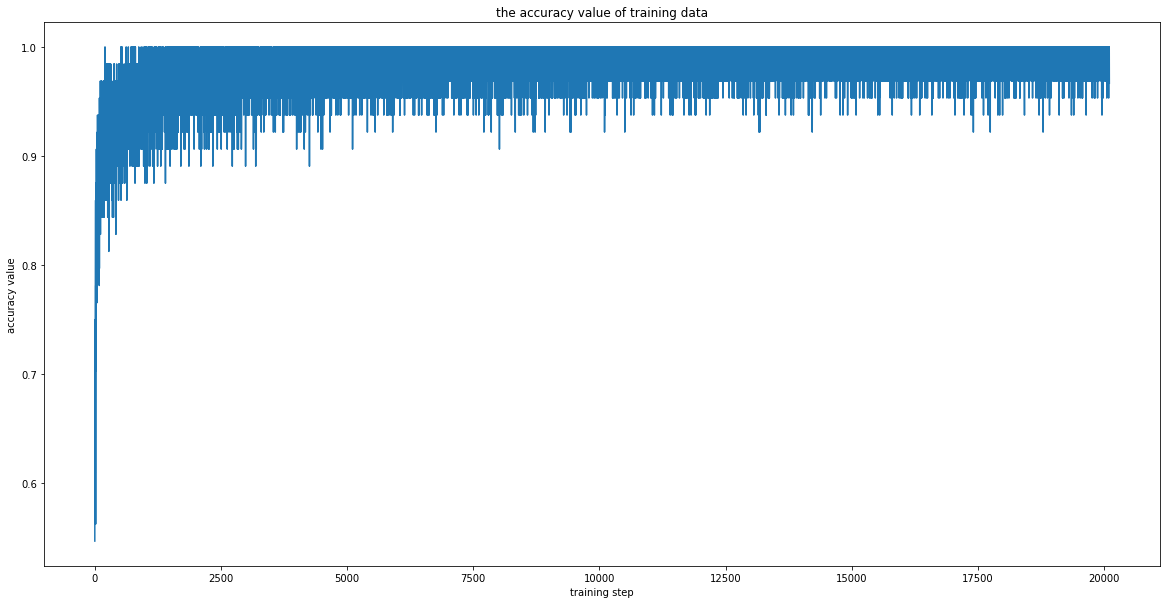

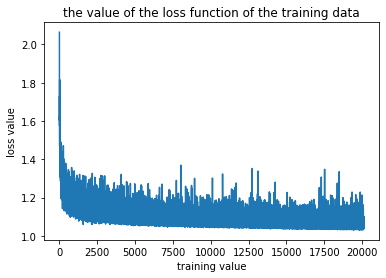

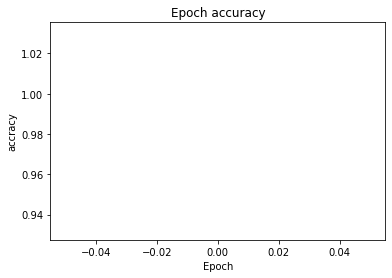

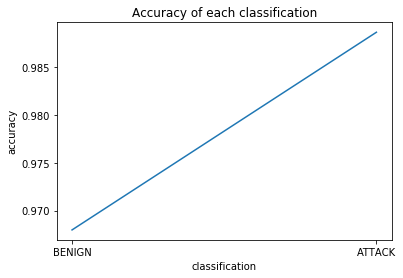

W1204 06:08:08.700784 140128707872576 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
I1204 06:08:08.703205 140128707872576 saver.py:1280] Restoring parameters from model_folder/saver/model.ckpt
W1204 06:08:08.733326 140128707872576 deprecation.py:323] From <string>:26: start_queue_runners (from tensorflow.python.training.queue_runner_impl) is deprecated and will be removed in a future version.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
W1204 06:08:08.734433 140128707872576 queue_runner_impl.py:471] `tf.train.start_queue_runners()` was called when no queue runners were defined. You can safely remove the call to this deprecated function.


confusion matrix in tensorflow: 
测试precision= 0.9932196329088738
[0.9878379826409972, 0.9960939735592056]


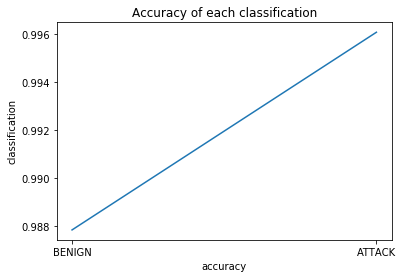

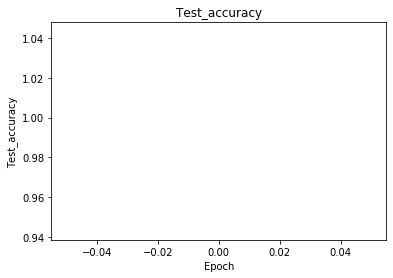

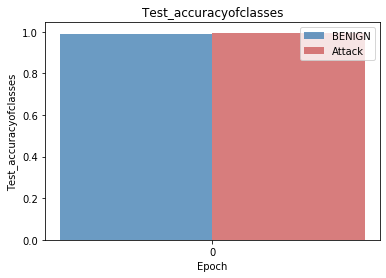

epoch为: 1
index: 0  loss_value: 1.0667756  accuracy_value: 0.96875
index: 1000  loss_value: 1.058111  accuracy_value: 0.984375
index: 2000  loss_value: 1.0629013  accuracy_value: 0.984375
index: 3000  loss_value: 1.0412008  accuracy_value: 1.0
index: 4000  loss_value: 1.052195  accuracy_value: 0.984375
index: 5000  loss_value: 1.0765082  accuracy_value: 0.984375
index: 6000  loss_value: 1.0382986  accuracy_value: 1.0
index: 7000  loss_value: 1.0335668  accuracy_value: 1.0
index: 8000  loss_value: 1.0518568  accuracy_value: 0.984375
index: 9000  loss_value: 1.0299909  accuracy_value: 1.0
index: 10000  loss_value: 1.0435241  accuracy_value: 1.0
index: 11000  loss_value: 1.0296024  accuracy_value: 1.0
index: 12000  loss_value: 1.0259869  accuracy_value: 1.0
index: 13000  loss_value: 1.0360634  accuracy_value: 0.984375
index: 14000  loss_value: 1.0186625  accuracy_value: 1.0
index: 15000  loss_value: 1.0294425  accuracy_value: 0.984375
index: 16000  loss_value: 1.0659564  accuracy_value: 0

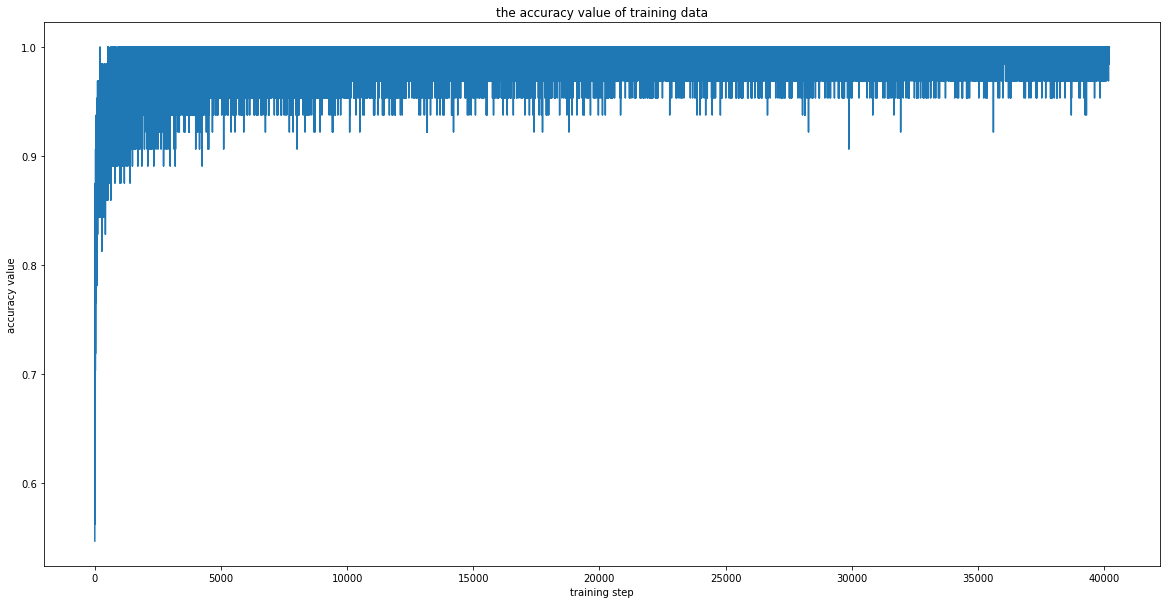

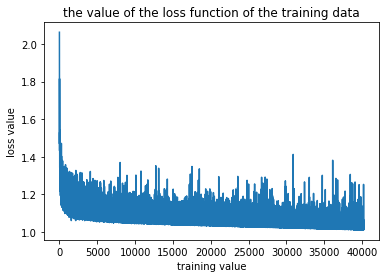

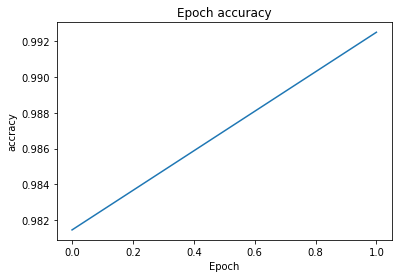

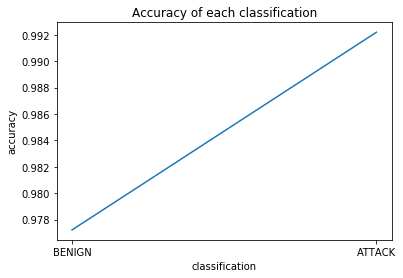

I1204 06:17:42.710958 140128707872576 saver.py:1280] Restoring parameters from model_folder/saver/model.ckpt
W1204 06:17:42.741928 140128707872576 queue_runner_impl.py:471] `tf.train.start_queue_runners()` was called when no queue runners were defined. You can safely remove the call to this deprecated function.


confusion matrix in tensorflow: 
测试precision= 0.9950662803422204
[0.9922920964961639, 0.9968517007970921]


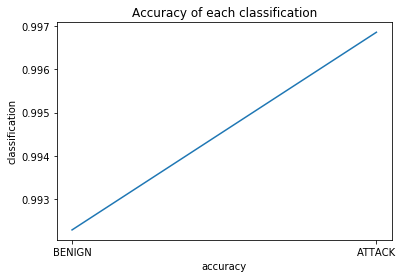

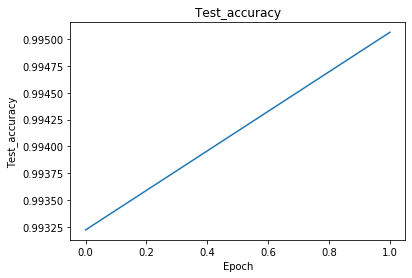

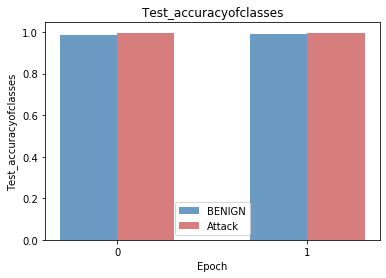

epoch为: 2
index: 0  loss_value: 1.0380218  accuracy_value: 0.984375
index: 1000  loss_value: 1.0261178  accuracy_value: 1.0
index: 3000  loss_value: 1.0254539  accuracy_value: 1.0
index: 4000  loss_value: 1.0389956  accuracy_value: 0.96875
index: 5000  loss_value: 1.0053402  accuracy_value: 1.0
index: 6000  loss_value: 1.0099849  accuracy_value: 1.0
index: 7000  loss_value: 1.0101833  accuracy_value: 1.0
index: 8000  loss_value: 1.014491  accuracy_value: 1.0
index: 9000  loss_value: 1.0460994  accuracy_value: 0.984375
index: 10000  loss_value: 1.0006952  accuracy_value: 1.0
index: 11000  loss_value: 1.044058  accuracy_value: 0.96875
index: 12000  loss_value: 1.0034429  accuracy_value: 1.0
index: 13000  loss_value: 1.0228331  accuracy_value: 0.984375
index: 14000  loss_value: 1.0006801  accuracy_value: 1.0
index: 15000  loss_value: 1.0467756  accuracy_value: 0.96875
index: 16000  loss_value: 1.0191172  accuracy_value: 1.0
index: 17000  loss_value: 1.0043133  accuracy_value: 1.0
index: 1

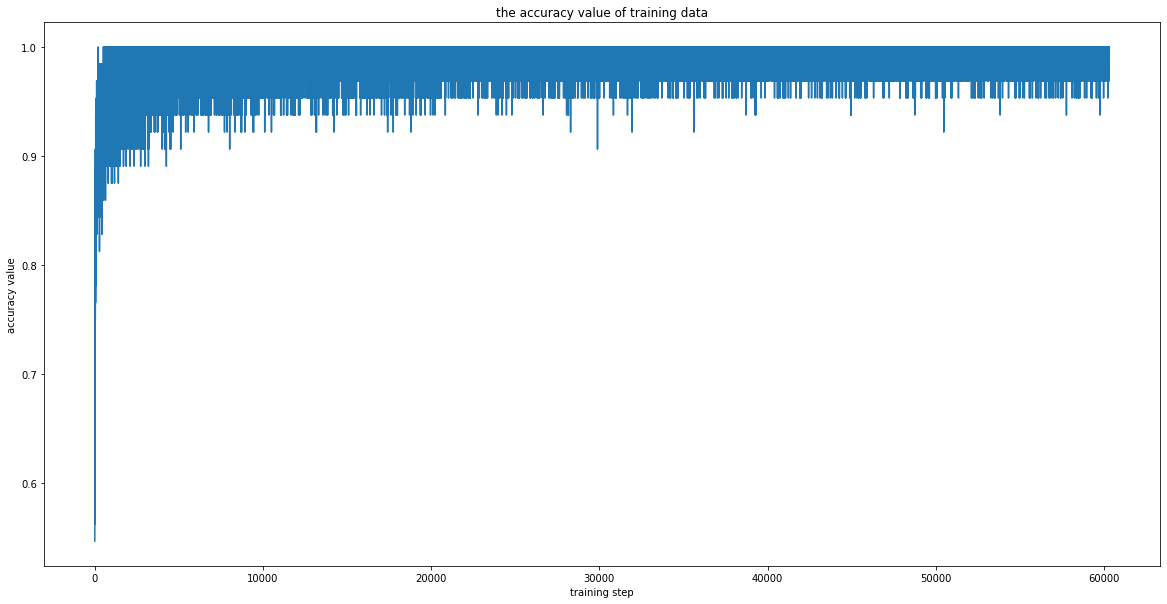

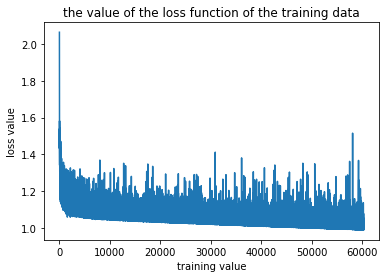

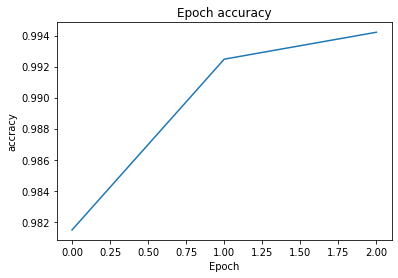

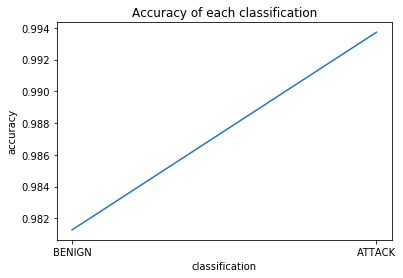

I1204 06:27:28.859150 140128707872576 saver.py:1280] Restoring parameters from model_folder/saver/model.ckpt
W1204 06:27:28.888813 140128707872576 queue_runner_impl.py:471] `tf.train.start_queue_runners()` was called when no queue runners were defined. You can safely remove the call to this deprecated function.


confusion matrix in tensorflow: 
测试precision= 0.9955574761241544
[0.992890698962185, 0.9972857456328649]


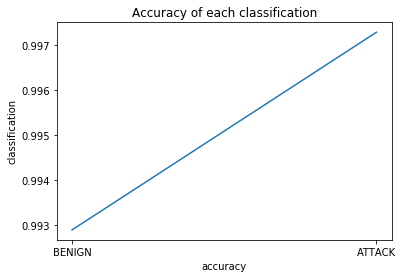

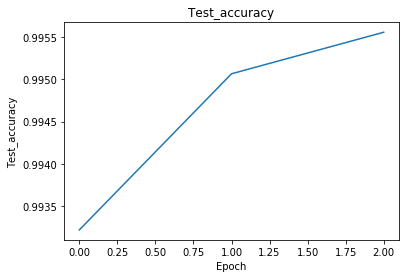

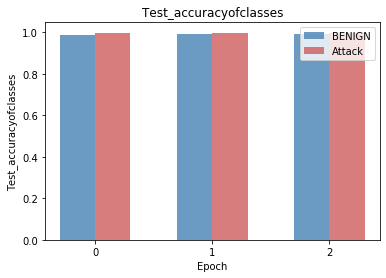

epoch为: 3
index: 0  loss_value: 0.99457246  accuracy_value: 1.0
index: 1000  loss_value: 1.0011696  accuracy_value: 0.984375
index: 2000  loss_value: 1.0084356  accuracy_value: 0.984375
index: 3000  loss_value: 1.0015261  accuracy_value: 1.0
index: 4000  loss_value: 0.9912609  accuracy_value: 1.0
index: 5000  loss_value: 0.99604106  accuracy_value: 1.0
index: 6000  loss_value: 1.006573  accuracy_value: 1.0
index: 7000  loss_value: 0.98801094  accuracy_value: 1.0
index: 8000  loss_value: 0.9899496  accuracy_value: 1.0
index: 9000  loss_value: 0.9932854  accuracy_value: 1.0
index: 10000  loss_value: 0.9854473  accuracy_value: 1.0
index: 11000  loss_value: 0.98219156  accuracy_value: 1.0
index: 12000  loss_value: 0.98121774  accuracy_value: 1.0
index: 13000  loss_value: 1.0049704  accuracy_value: 0.984375
index: 14000  loss_value: 0.9822216  accuracy_value: 1.0
index: 15000  loss_value: 0.9789237  accuracy_value: 1.0
index: 16000  loss_value: 1.0086  accuracy_value: 0.984375
index: 17000 

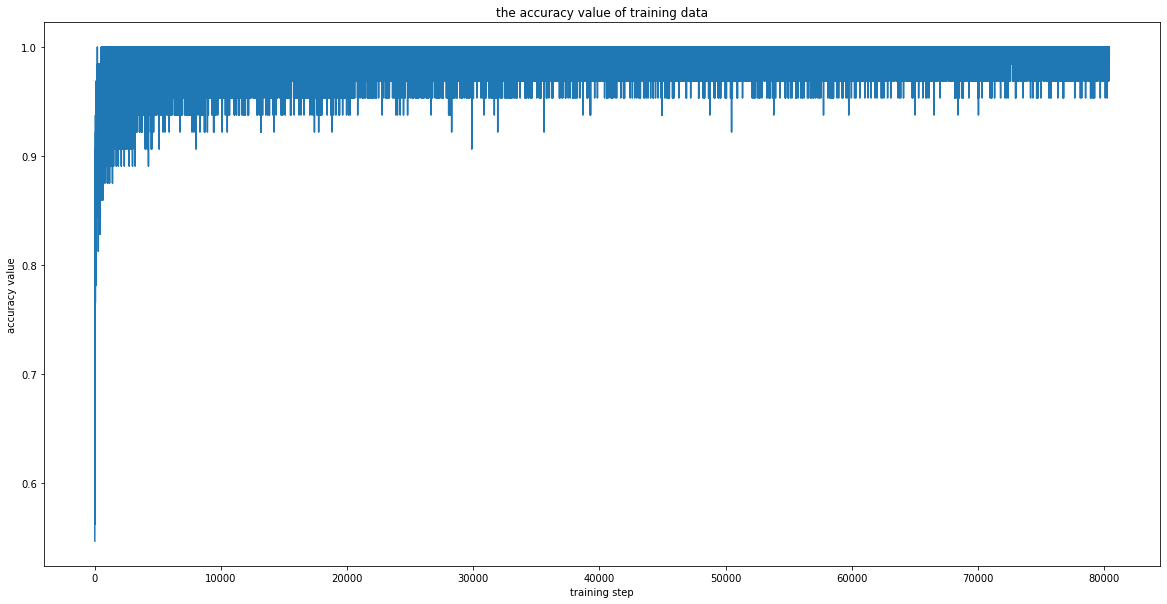

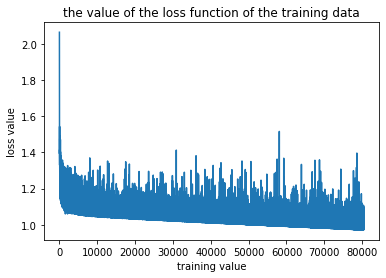

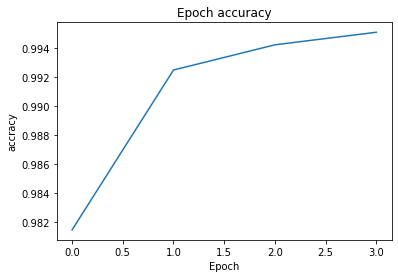

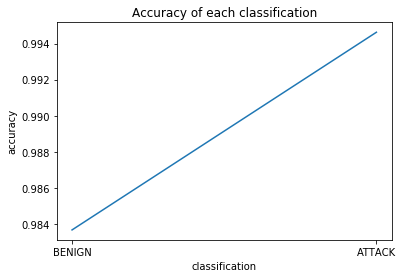

I1204 06:37:33.506865 140128707872576 saver.py:1280] Restoring parameters from model_folder/saver/model.ckpt
W1204 06:37:33.539936 140128707872576 queue_runner_impl.py:471] `tf.train.start_queue_runners()` was called when no queue runners were defined. You can safely remove the call to this deprecated function.


confusion matrix in tensorflow: 
测试precision= 0.9959305362116991
[0.9935966706259545, 0.9974812404890592]


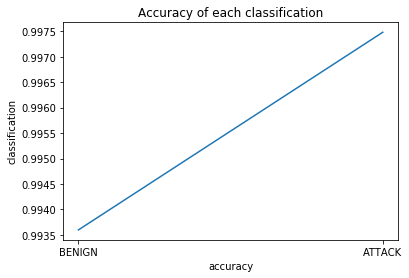

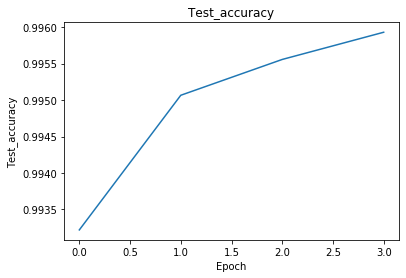

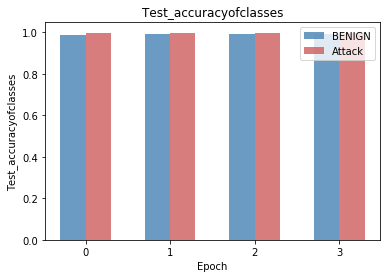

epoch为: 4
index: 0  loss_value: 1.0492504  accuracy_value: 0.984375
index: 1000  loss_value: 0.97138095  accuracy_value: 1.0
index: 2000  loss_value: 0.9752698  accuracy_value: 1.0
index: 3000  loss_value: 0.97465384  accuracy_value: 1.0
index: 4000  loss_value: 0.97252375  accuracy_value: 1.0
index: 5000  loss_value: 0.9673648  accuracy_value: 1.0
index: 6000  loss_value: 0.97282267  accuracy_value: 1.0
index: 7000  loss_value: 0.9701147  accuracy_value: 1.0
index: 8000  loss_value: 0.99387765  accuracy_value: 0.984375
index: 9000  loss_value: 0.96771544  accuracy_value: 1.0
index: 10000  loss_value: 1.0010214  accuracy_value: 0.984375
index: 11000  loss_value: 0.9646764  accuracy_value: 1.0
index: 12000  loss_value: 0.9650566  accuracy_value: 1.0
index: 13000  loss_value: 0.95930105  accuracy_value: 1.0
index: 14000  loss_value: 0.9603271  accuracy_value: 1.0
index: 15000  loss_value: 0.9907682  accuracy_value: 0.984375
index: 16000  loss_value: 0.95858806  accuracy_value: 1.0
index:

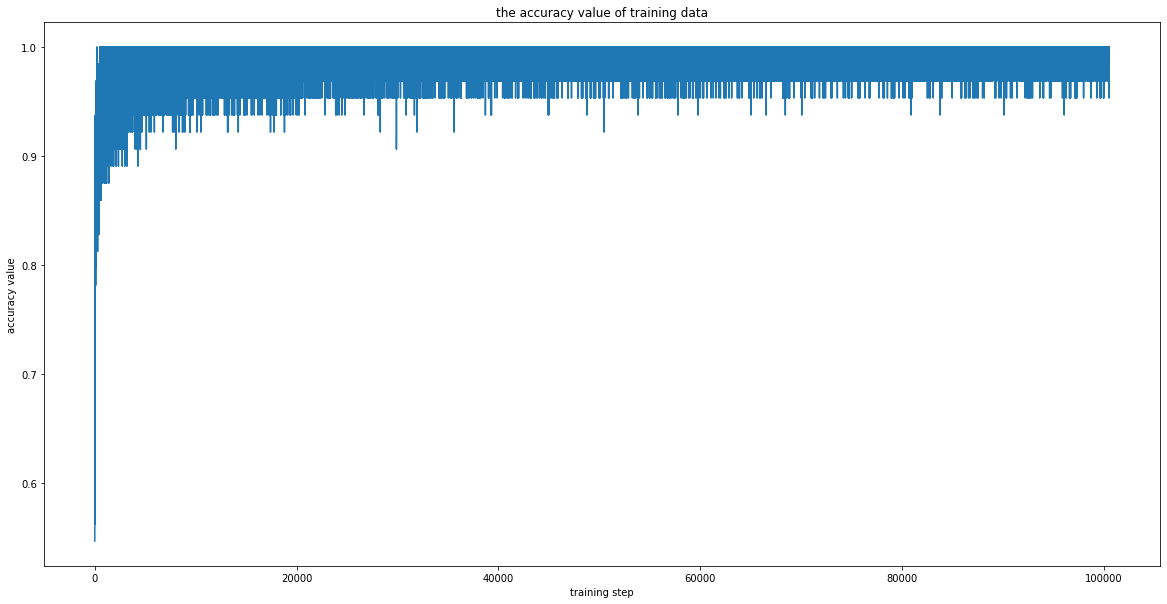

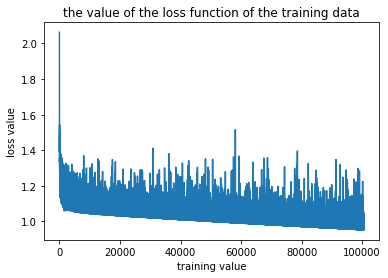

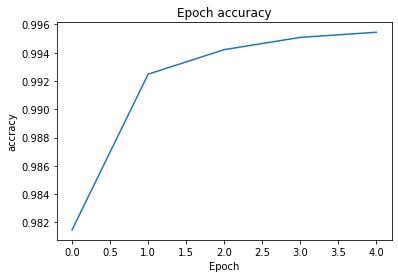

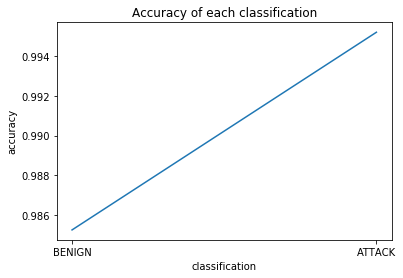

I1204 06:48:00.250571 140128707872576 saver.py:1280] Restoring parameters from model_folder/saver/model.ckpt
W1204 06:48:00.282938 140128707872576 queue_runner_impl.py:471] `tf.train.start_queue_runners()` was called when no queue runners were defined. You can safely remove the call to this deprecated function.


confusion matrix in tensorflow: 
测试precision= 0.9958590330282531
[0.9926672859133293, 0.9978677326413402]


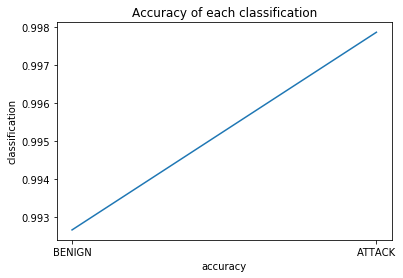

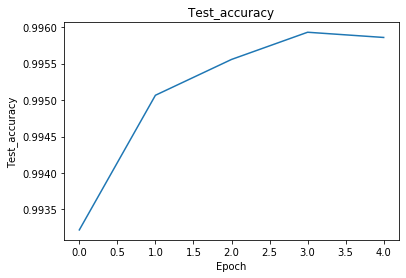

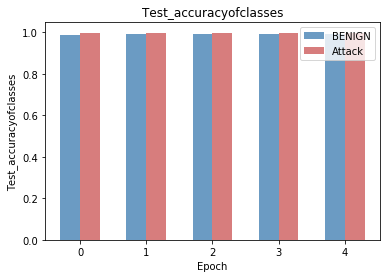

epoch为: 5
index: 0  loss_value: 0.9541317  accuracy_value: 1.0
index: 1000  loss_value: 0.9530098  accuracy_value: 1.0
index: 2000  loss_value: 0.9518318  accuracy_value: 1.0
index: 3000  loss_value: 0.9526233  accuracy_value: 1.0
index: 4000  loss_value: 0.9546848  accuracy_value: 1.0
index: 5000  loss_value: 0.97458583  accuracy_value: 0.984375
index: 6000  loss_value: 0.9505363  accuracy_value: 1.0
index: 7000  loss_value: 1.001065  accuracy_value: 0.984375
index: 8000  loss_value: 0.9519785  accuracy_value: 1.0
index: 9000  loss_value: 0.9768231  accuracy_value: 0.984375
index: 10000  loss_value: 0.94899887  accuracy_value: 1.0
index: 11000  loss_value: 0.9454658  accuracy_value: 1.0
index: 12000  loss_value: 0.95498025  accuracy_value: 1.0
index: 13000  loss_value: 0.97562605  accuracy_value: 0.984375
index: 14000  loss_value: 0.9438823  accuracy_value: 1.0
index: 15000  loss_value: 0.94118875  accuracy_value: 1.0
index: 16000  loss_value: 0.9383717  accuracy_value: 1.0
index: 170

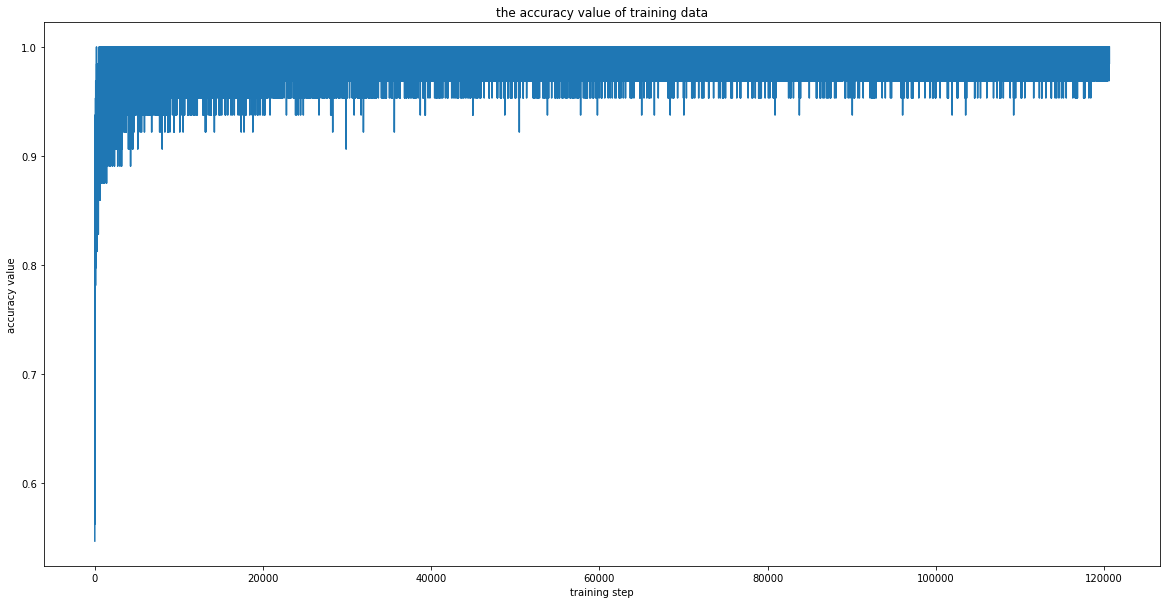

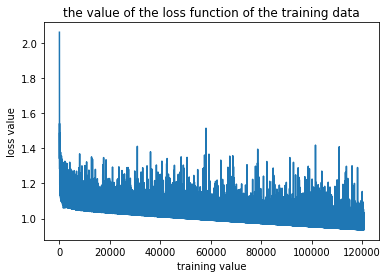

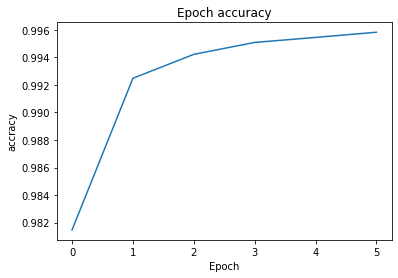

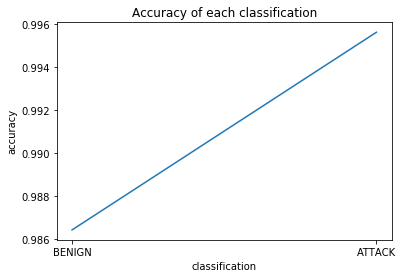

I1204 06:58:52.955532 140128707872576 saver.py:1280] Restoring parameters from model_folder/saver/model.ckpt
W1204 06:58:52.986378 140128707872576 queue_runner_impl.py:471] `tf.train.start_queue_runners()` was called when no queue runners were defined. You can safely remove the call to this deprecated function.


confusion matrix in tensorflow: 
测试precision= 0.9961699164345403
[0.9936942891338133, 0.9977962010704167]


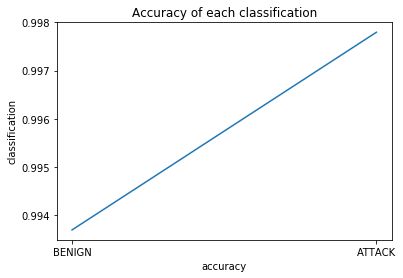

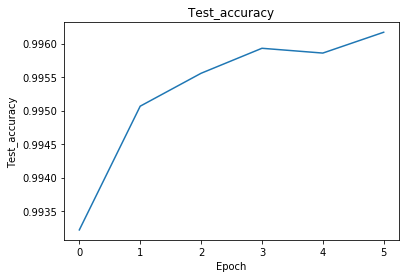

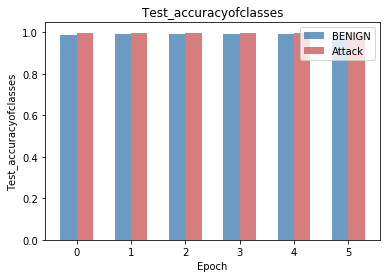

epoch为: 6
index: 0  loss_value: 0.9430945  accuracy_value: 1.0
index: 1000  loss_value: 0.9351704  accuracy_value: 1.0
index: 2000  loss_value: 0.934096  accuracy_value: 1.0
index: 3000  loss_value: 0.96506697  accuracy_value: 0.984375
index: 4000  loss_value: 0.9355364  accuracy_value: 1.0
index: 5000  loss_value: 0.93420815  accuracy_value: 1.0
index: 6000  loss_value: 0.93511015  accuracy_value: 1.0
index: 7000  loss_value: 0.9315156  accuracy_value: 1.0
index: 8000  loss_value: 0.9685595  accuracy_value: 0.984375
index: 9000  loss_value: 0.9277102  accuracy_value: 1.0
index: 10000  loss_value: 0.98056626  accuracy_value: 0.96875
index: 11000  loss_value: 0.9300859  accuracy_value: 1.0
index: 12000  loss_value: 0.9287223  accuracy_value: 1.0
index: 13000  loss_value: 0.9265737  accuracy_value: 1.0
index: 14000  loss_value: 0.92433935  accuracy_value: 1.0
index: 15000  loss_value: 0.9243577  accuracy_value: 1.0
index: 16000  loss_value: 0.9373733  accuracy_value: 0.984375
index: 1700

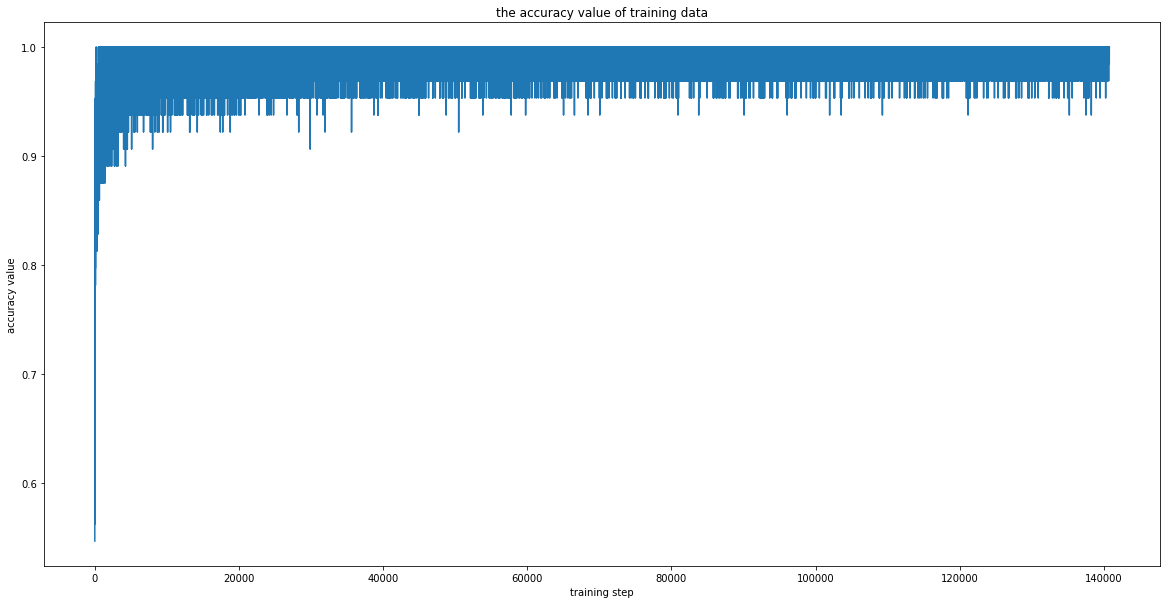

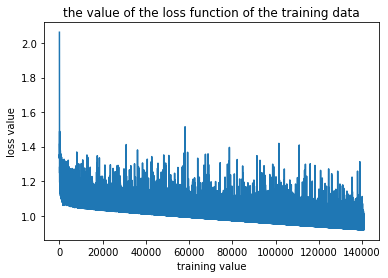

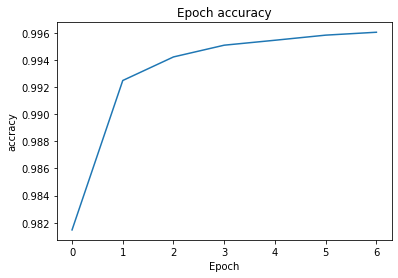

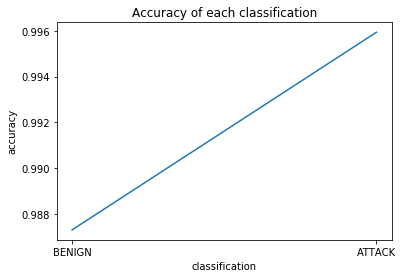

I1204 07:10:17.522156 140128707872576 saver.py:1280] Restoring parameters from model_folder/saver/model.ckpt
W1204 07:10:17.555302 140128707872576 queue_runner_impl.py:471] `tf.train.start_queue_runners()` was called when no queue runners were defined. You can safely remove the call to this deprecated function.


confusion matrix in tensorflow: 
测试precision= 0.9963346846398726
[0.9942835195655475, 0.9977342434519636]


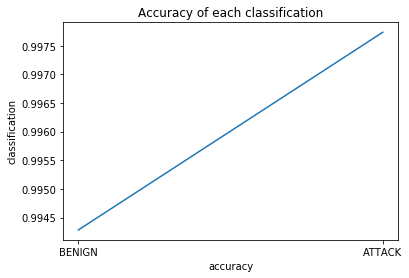

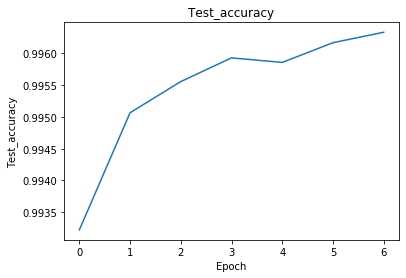

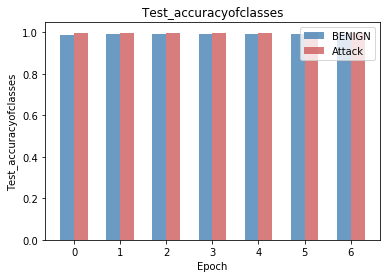

epoch为: 7
index: 0  loss_value: 1.0503758  accuracy_value: 0.984375
index: 1000  loss_value: 0.9165635  accuracy_value: 1.0
index: 2000  loss_value: 0.9177696  accuracy_value: 1.0
index: 3000  loss_value: 0.9161835  accuracy_value: 1.0
index: 4000  loss_value: 0.9498789  accuracy_value: 0.984375
index: 5000  loss_value: 0.9189793  accuracy_value: 1.0
index: 6000  loss_value: 0.9155627  accuracy_value: 1.0
index: 7000  loss_value: 0.9117941  accuracy_value: 1.0
index: 8000  loss_value: 0.91355157  accuracy_value: 1.0
index: 9000  loss_value: 0.9203876  accuracy_value: 1.0
index: 10000  loss_value: 0.9127915  accuracy_value: 1.0
index: 11000  loss_value: 0.9116325  accuracy_value: 1.0
index: 12000  loss_value: 0.90844136  accuracy_value: 1.0
index: 13000  loss_value: 0.9517687  accuracy_value: 0.984375
index: 14000  loss_value: 0.9079372  accuracy_value: 1.0
index: 15000  loss_value: 0.9078659  accuracy_value: 1.0
index: 16000  loss_value: 0.90466666  accuracy_value: 1.0
index: 17000  lo

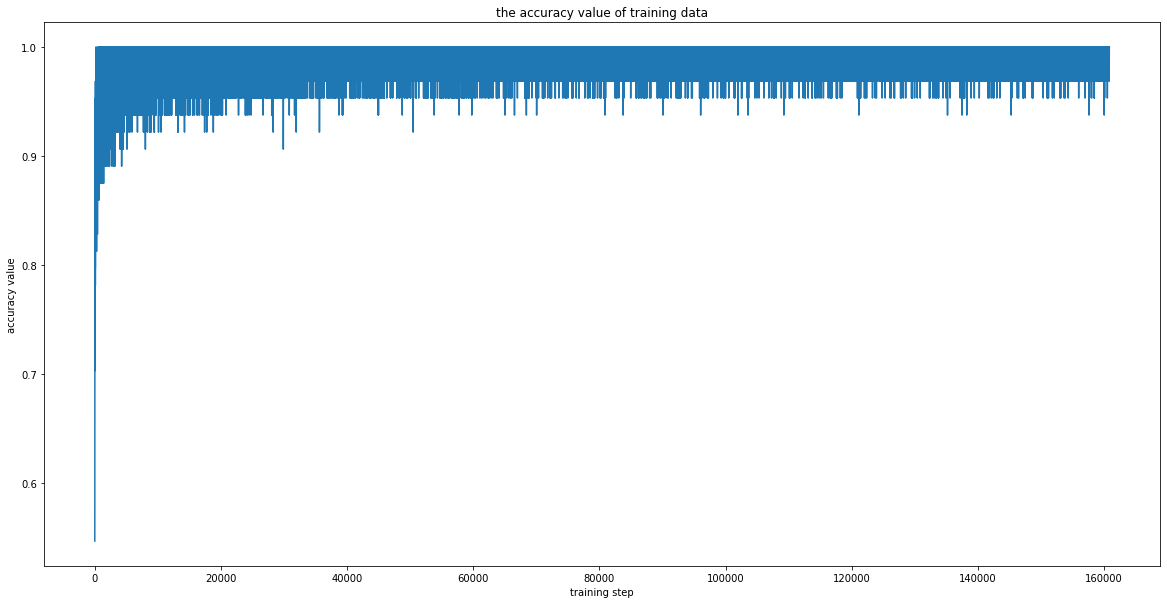

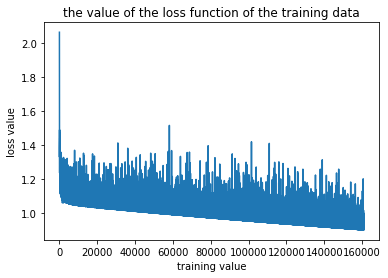

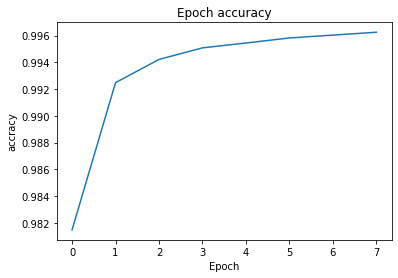

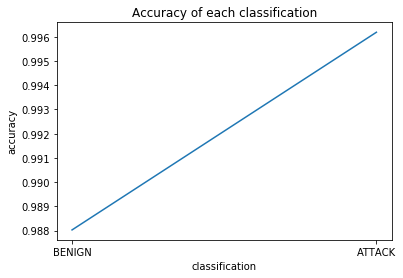

I1204 07:22:07.538709 140128707872576 saver.py:1280] Restoring parameters from model_folder/saver/model.ckpt
W1204 07:22:07.571506 140128707872576 queue_runner_impl.py:471] `tf.train.start_queue_runners()` was called when no queue runners were defined. You can safely remove the call to this deprecated function.


confusion matrix in tensorflow: 
测试precision= 0.996399970155193
[0.9943193490474191, 0.9978153128443387]


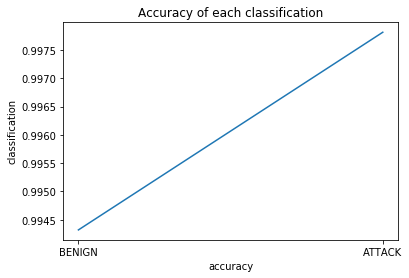

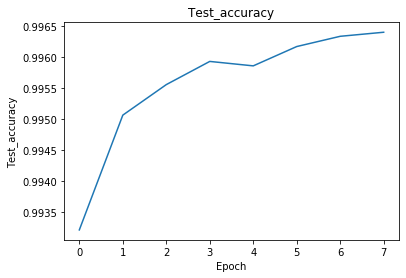

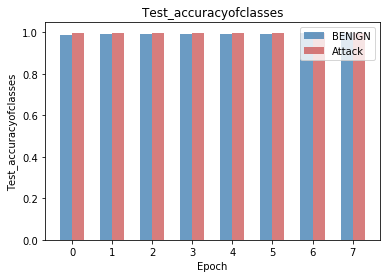

epoch为: 8
index: 0  loss_value: 0.9008892  accuracy_value: 1.0
index: 1000  loss_value: 0.9020378  accuracy_value: 1.0
index: 2000  loss_value: 0.9043949  accuracy_value: 1.0
index: 3000  loss_value: 0.9065463  accuracy_value: 1.0
index: 4000  loss_value: 0.9002463  accuracy_value: 1.0
index: 5000  loss_value: 0.8972438  accuracy_value: 1.0
index: 6000  loss_value: 0.97602355  accuracy_value: 0.984375
index: 7000  loss_value: 0.8966222  accuracy_value: 1.0
index: 8000  loss_value: 0.90337104  accuracy_value: 1.0
index: 9000  loss_value: 0.90811574  accuracy_value: 1.0
index: 10000  loss_value: 0.8991609  accuracy_value: 1.0
index: 11000  loss_value: 0.89236945  accuracy_value: 1.0
index: 12000  loss_value: 0.8976019  accuracy_value: 1.0
index: 13000  loss_value: 0.9011068  accuracy_value: 1.0
index: 14000  loss_value: 0.8953828  accuracy_value: 1.0
index: 15000  loss_value: 0.8931435  accuracy_value: 1.0
index: 16000  loss_value: 0.8890143  accuracy_value: 1.0
index: 17000  loss_value:

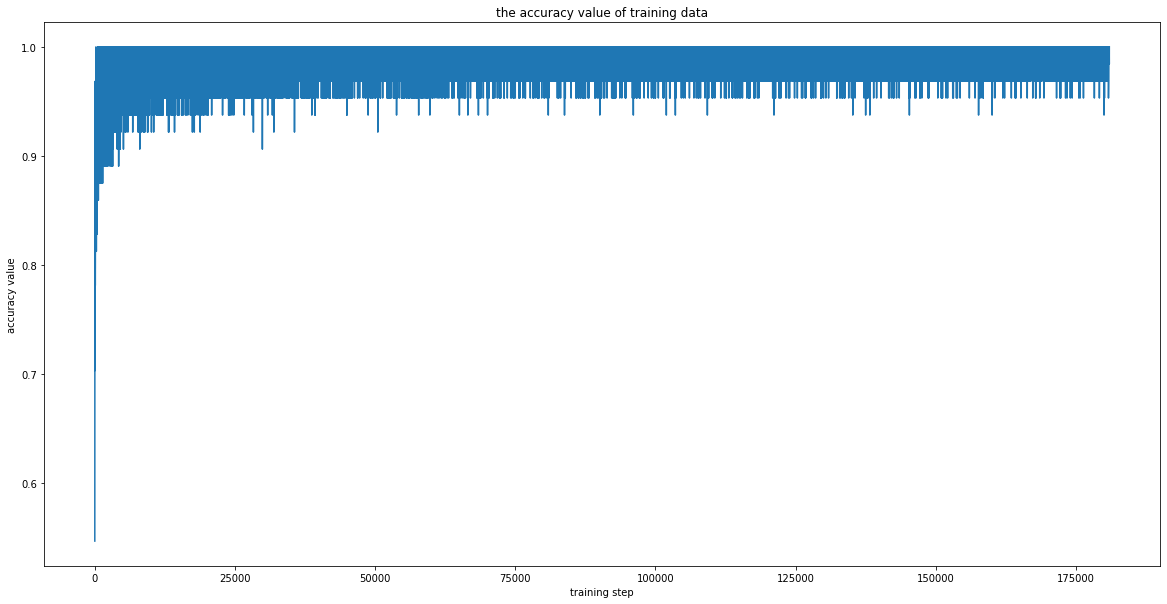

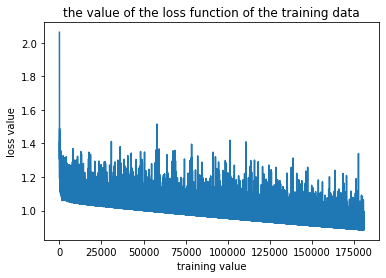

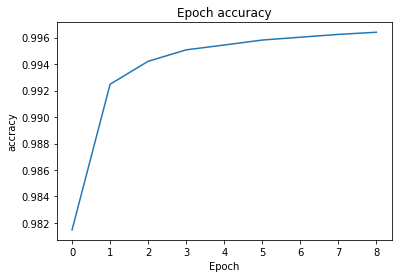

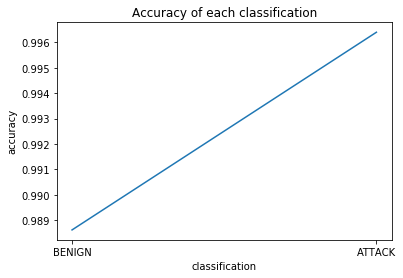

I1204 07:34:49.608867 140128707872576 saver.py:1280] Restoring parameters from model_folder/saver/model.ckpt
W1204 07:34:49.642408 140128707872576 queue_runner_impl.py:471] `tf.train.start_queue_runners()` was called when no queue runners were defined. You can safely remove the call to this deprecated function.


confusion matrix in tensorflow: 
测试precision= 0.9968538599283725
[0.9940787710994016, 0.9986404617659687]


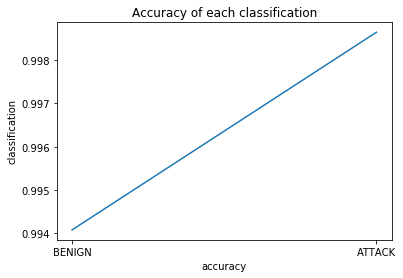

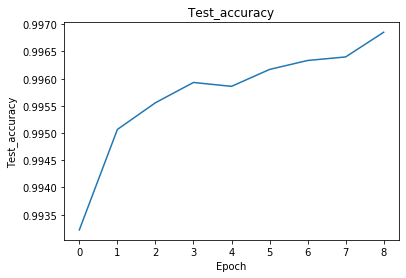

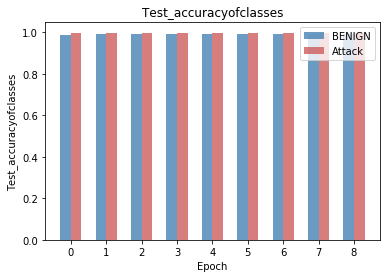

epoch为: 9
index: 0  loss_value: 0.8872885  accuracy_value: 1.0
index: 1000  loss_value: 0.89267033  accuracy_value: 1.0
index: 2000  loss_value: 0.88404816  accuracy_value: 1.0
index: 3000  loss_value: 0.8855938  accuracy_value: 1.0
index: 4000  loss_value: 0.8873013  accuracy_value: 1.0
index: 5000  loss_value: 0.8994319  accuracy_value: 0.984375
index: 6000  loss_value: 0.8843596  accuracy_value: 1.0
index: 7000  loss_value: 0.8788006  accuracy_value: 1.0
index: 8000  loss_value: 0.87822956  accuracy_value: 1.0
index: 9000  loss_value: 0.87852424  accuracy_value: 1.0
index: 10000  loss_value: 0.8785416  accuracy_value: 1.0
index: 11000  loss_value: 0.88312364  accuracy_value: 1.0
index: 12000  loss_value: 0.8781158  accuracy_value: 1.0
index: 13000  loss_value: 0.87486494  accuracy_value: 1.0
index: 14000  loss_value: 0.94656074  accuracy_value: 0.984375
index: 15000  loss_value: 0.87277824  accuracy_value: 1.0
index: 16000  loss_value: 0.88242674  accuracy_value: 1.0
index: 17000  l

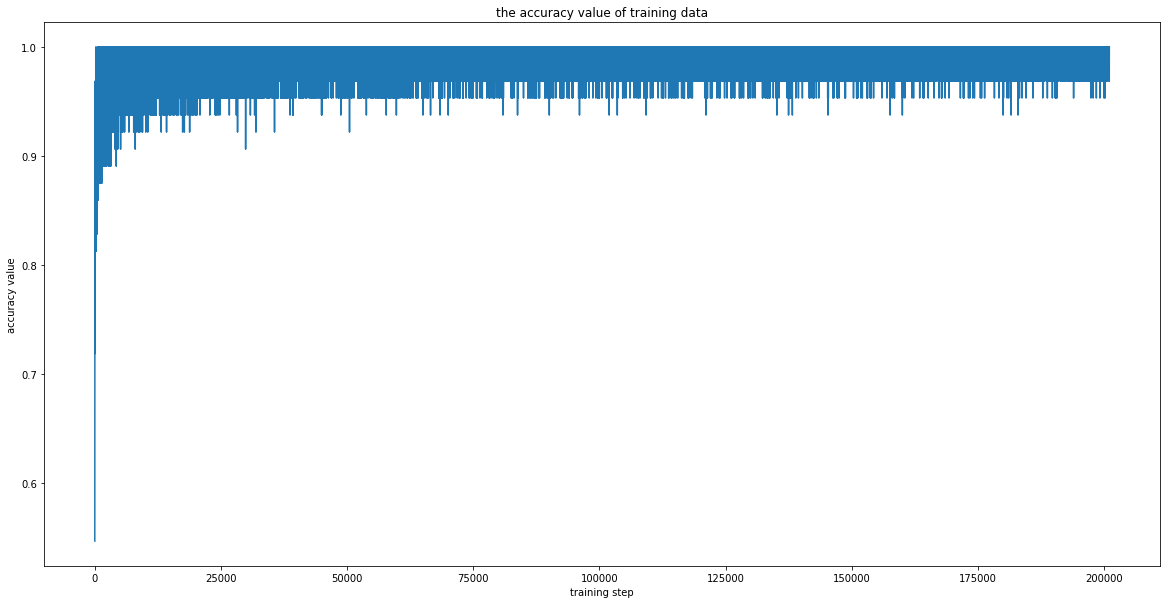

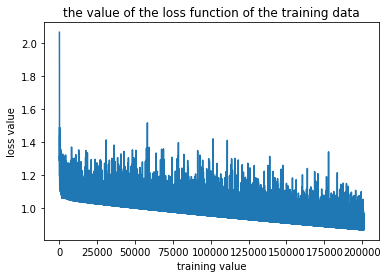

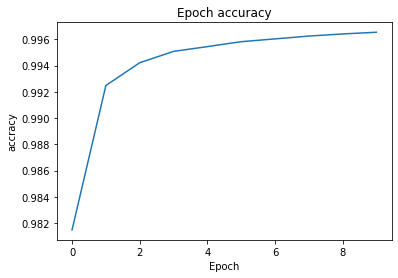

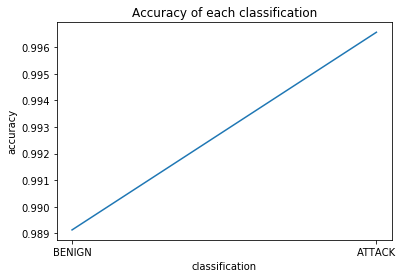

I1204 07:47:45.076457 140128707872576 saver.py:1280] Restoring parameters from model_folder/saver/model.ckpt
W1204 07:47:45.111365 140128707872576 queue_runner_impl.py:471] `tf.train.start_queue_runners()` was called when no queue runners were defined. You can safely remove the call to this deprecated function.


confusion matrix in tensorflow: 
测试precision= 0.9967637037405491
[0.9951679602718804, 0.9979202343075477]


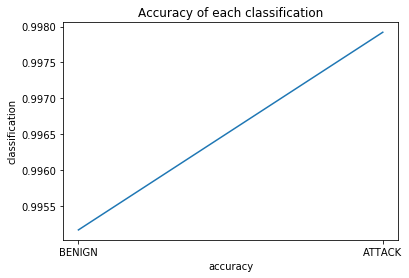

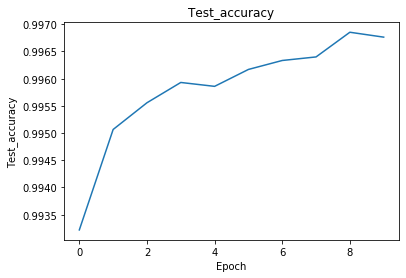

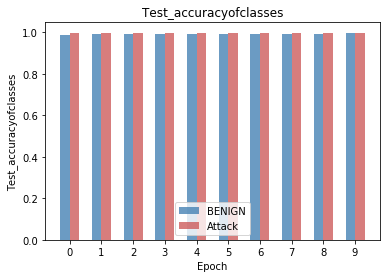

epoch为: 10
index: 0  loss_value: 0.87052345  accuracy_value: 1.0
index: 1000  loss_value: 0.8783077  accuracy_value: 1.0
index: 2000  loss_value: 0.86767954  accuracy_value: 1.0
index: 3000  loss_value: 0.8672636  accuracy_value: 1.0
index: 4000  loss_value: 0.89941514  accuracy_value: 0.984375
index: 5000  loss_value: 0.8730807  accuracy_value: 1.0
index: 6000  loss_value: 0.8812959  accuracy_value: 1.0
index: 7000  loss_value: 0.872565  accuracy_value: 1.0
index: 8000  loss_value: 0.86266744  accuracy_value: 1.0
index: 9000  loss_value: 0.8617134  accuracy_value: 1.0
index: 10000  loss_value: 0.8639973  accuracy_value: 1.0
index: 11000  loss_value: 0.86238927  accuracy_value: 1.0
index: 12000  loss_value: 0.8602348  accuracy_value: 1.0
index: 13000  loss_value: 0.9506223  accuracy_value: 0.984375
index: 14000  loss_value: 0.8587376  accuracy_value: 1.0
index: 15000  loss_value: 0.8588687  accuracy_value: 1.0
index: 16000  loss_value: 0.85676956  accuracy_value: 1.0
index: 17000  loss

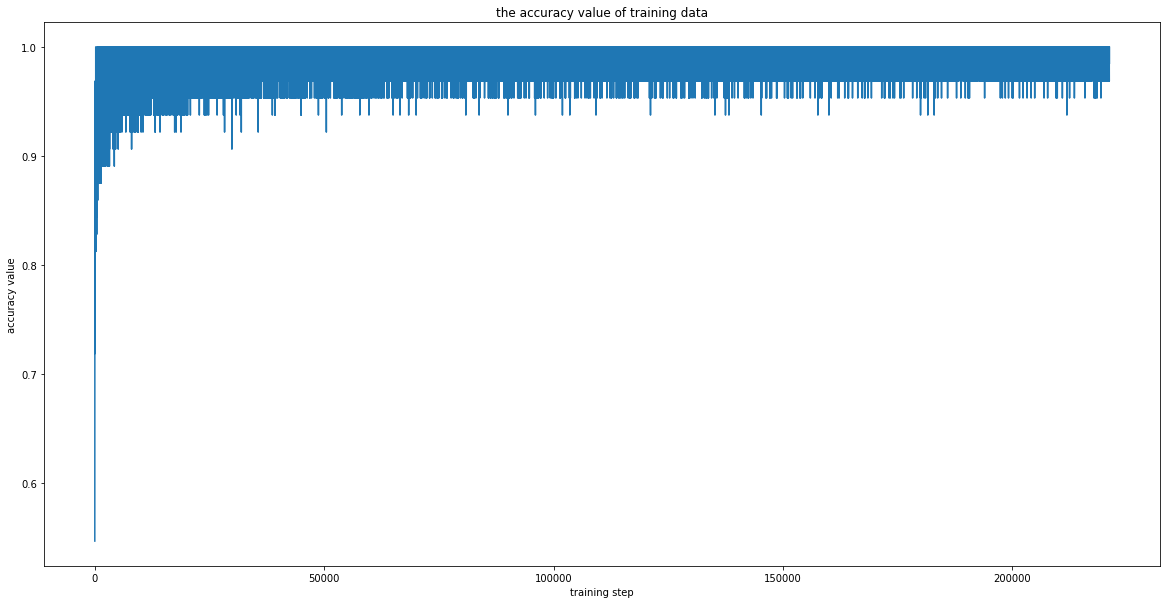

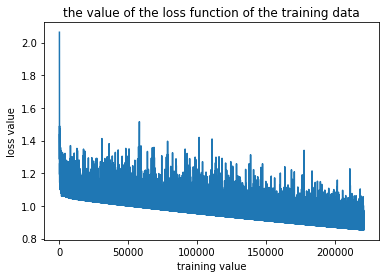

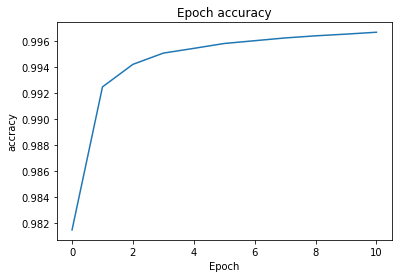

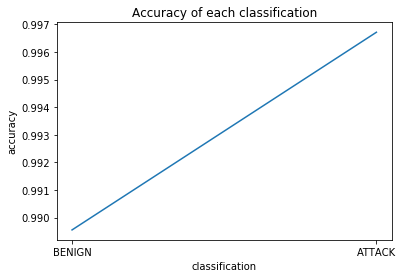

I1204 08:01:29.172415 140128707872576 saver.py:1280] Restoring parameters from model_folder/saver/model.ckpt
W1204 08:01:29.205075 140128707872576 queue_runner_impl.py:471] `tf.train.start_queue_runners()` was called when no queue runners were defined. You can safely remove the call to this deprecated function.


confusion matrix in tensorflow: 
测试precision= 0.9969222542777557
[0.9958826051230752, 0.9977818695262264]


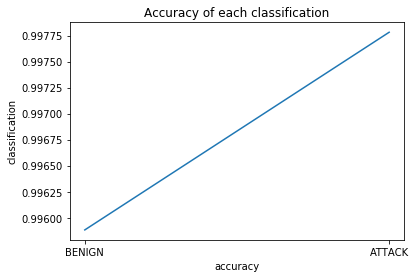

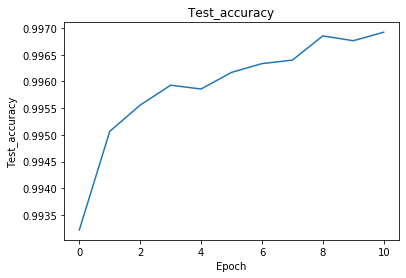

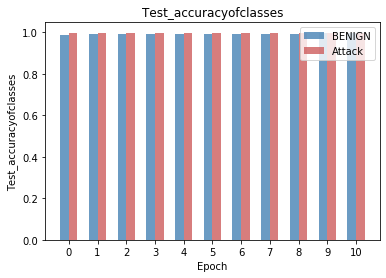

epoch为: 11
index: 0  loss_value: 0.8730888  accuracy_value: 0.984375
index: 1000  loss_value: 0.8807878  accuracy_value: 0.984375
index: 2000  loss_value: 0.8515817  accuracy_value: 1.0
index: 3000  loss_value: 0.8513157  accuracy_value: 1.0
index: 4000  loss_value: 0.851703  accuracy_value: 1.0
index: 5000  loss_value: 0.8525137  accuracy_value: 1.0
index: 6000  loss_value: 0.86794394  accuracy_value: 0.984375
index: 7000  loss_value: 0.8487102  accuracy_value: 1.0
index: 8000  loss_value: 0.8558166  accuracy_value: 1.0
index: 9000  loss_value: 0.92015547  accuracy_value: 0.984375
index: 10000  loss_value: 0.873618  accuracy_value: 0.984375
index: 11000  loss_value: 0.84815866  accuracy_value: 1.0
index: 12000  loss_value: 0.85022753  accuracy_value: 1.0
index: 13000  loss_value: 0.8447132  accuracy_value: 1.0
index: 14000  loss_value: 0.85506076  accuracy_value: 1.0
index: 15000  loss_value: 0.8426273  accuracy_value: 1.0
index: 16000  loss_value: 0.84797287  accuracy_value: 1.0
inde

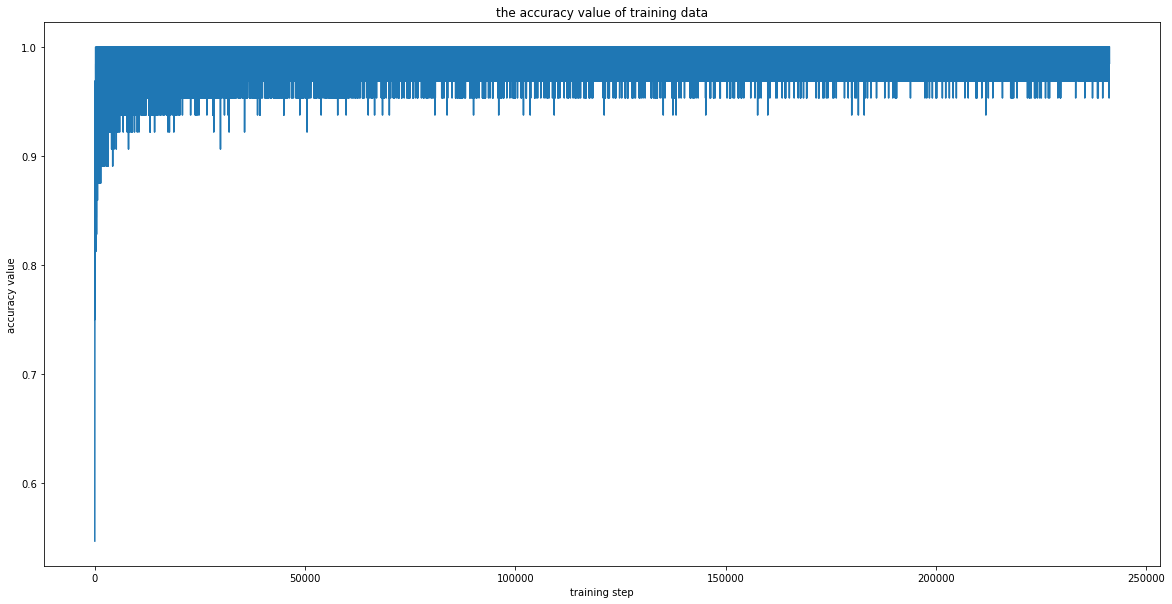

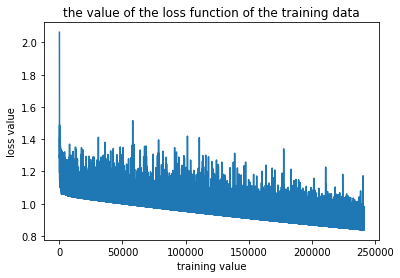

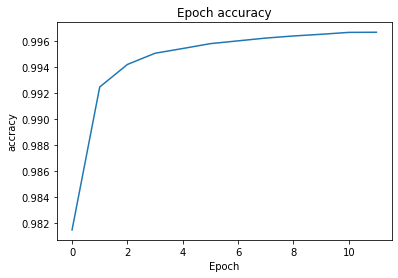

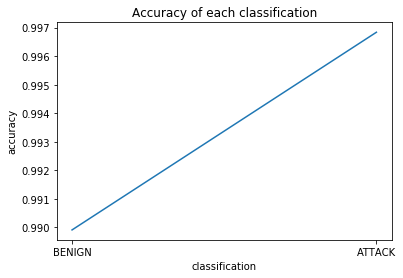

I1204 08:16:05.351694 140128707872576 saver.py:1280] Restoring parameters from model_folder/saver/model.ckpt
W1204 08:16:05.385432 140128707872576 queue_runner_impl.py:471] `tf.train.start_queue_runners()` was called when no queue runners were defined. You can safely remove the call to this deprecated function.


confusion matrix in tensorflow: 
测试precision= 0.9971771786709113
[0.9946946285346814, 0.9988074681116973]


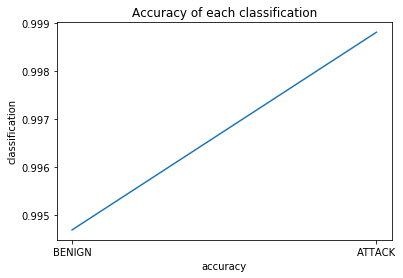

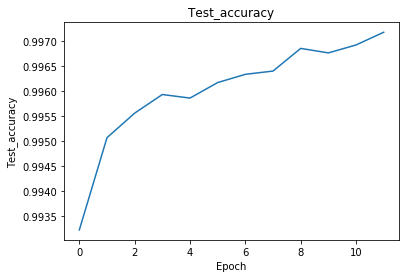

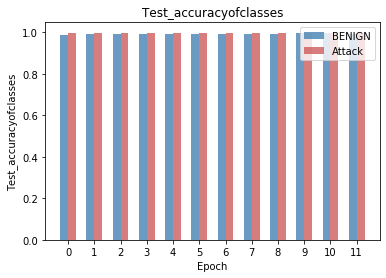

epoch为: 12
index: 0  loss_value: 0.83836186  accuracy_value: 1.0
index: 1000  loss_value: 0.8436387  accuracy_value: 1.0
index: 2000  loss_value: 0.8590947  accuracy_value: 0.984375
index: 3000  loss_value: 0.84035254  accuracy_value: 1.0
index: 4000  loss_value: 0.8414824  accuracy_value: 1.0
index: 5000  loss_value: 0.8367295  accuracy_value: 1.0
index: 6000  loss_value: 0.8342779  accuracy_value: 1.0
index: 7000  loss_value: 0.8356423  accuracy_value: 1.0
index: 8000  loss_value: 0.8380033  accuracy_value: 1.0
index: 9000  loss_value: 0.8327883  accuracy_value: 1.0
index: 10000  loss_value: 0.8307946  accuracy_value: 1.0
index: 11000  loss_value: 0.8304984  accuracy_value: 1.0
index: 12000  loss_value: 0.83401364  accuracy_value: 1.0
index: 13000  loss_value: 0.8413694  accuracy_value: 1.0
index: 14000  loss_value: 0.8279258  accuracy_value: 1.0
index: 15000  loss_value: 0.8314034  accuracy_value: 1.0
index: 16000  loss_value: 0.8306439  accuracy_value: 1.0
index: 17000  loss_value:

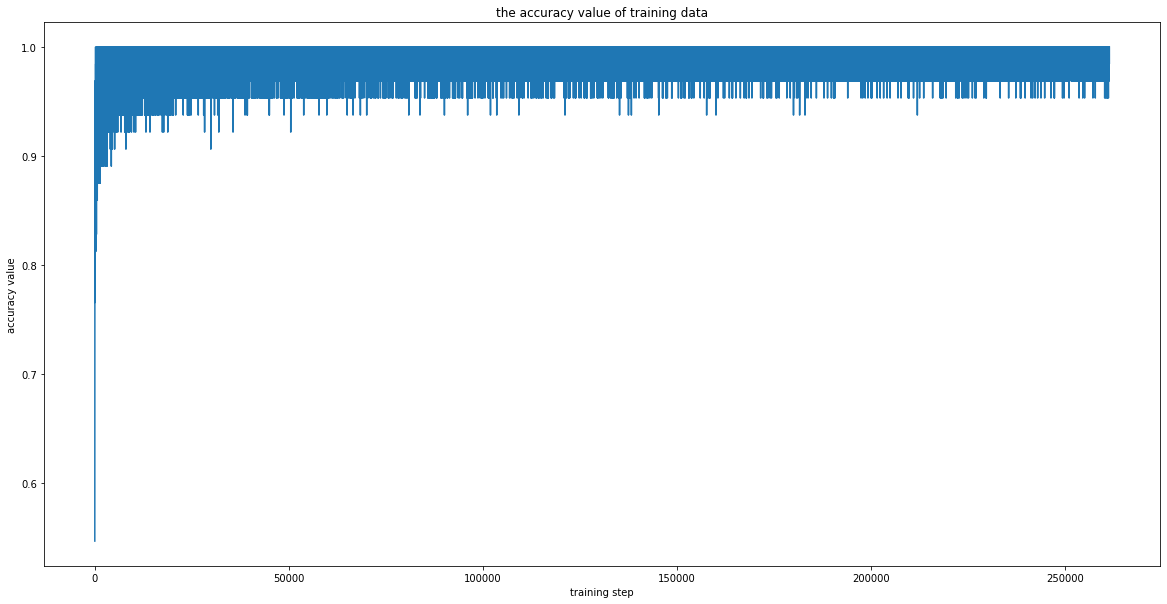

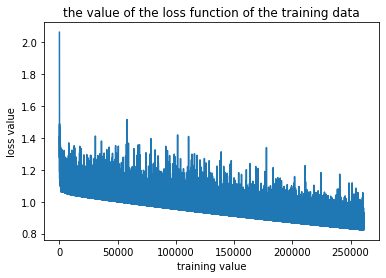

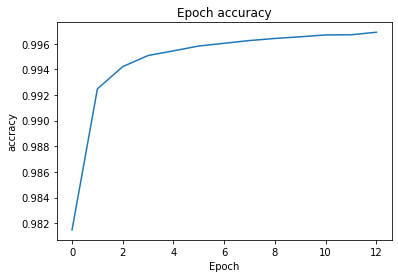

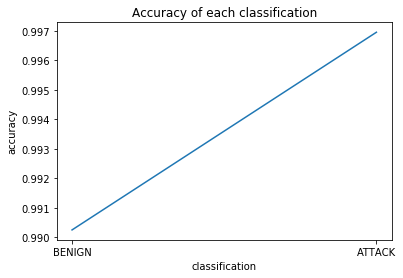

I1204 08:31:25.304003 140128707872576 saver.py:1280] Restoring parameters from model_folder/saver/model.ckpt
W1204 08:31:25.337857 140128707872576 queue_runner_impl.py:471] `tf.train.start_queue_runners()` was called when no queue runners were defined. You can safely remove the call to this deprecated function.


confusion matrix in tensorflow: 
测试precision= 0.9970808048149622
[0.9954270607254182, 0.9982684354384007]


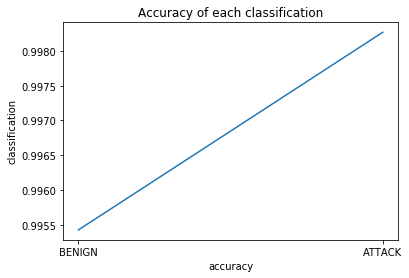

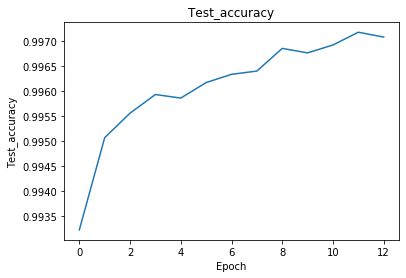

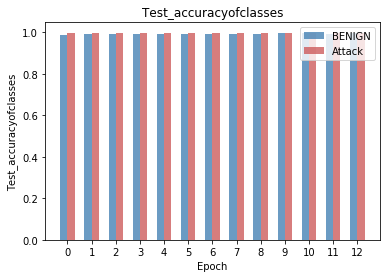

epoch为: 13
index: 0  loss_value: 0.82399654  accuracy_value: 1.0
index: 1000  loss_value: 0.8240032  accuracy_value: 1.0
index: 2000  loss_value: 0.8429422  accuracy_value: 0.984375
index: 3000  loss_value: 0.8237167  accuracy_value: 1.0
index: 4000  loss_value: 0.8534579  accuracy_value: 0.96875
index: 5000  loss_value: 0.82315814  accuracy_value: 1.0
index: 6000  loss_value: 0.82040846  accuracy_value: 1.0
index: 7000  loss_value: 0.82607234  accuracy_value: 1.0
index: 8000  loss_value: 0.81781125  accuracy_value: 1.0
index: 9000  loss_value: 0.81735957  accuracy_value: 1.0
index: 10000  loss_value: 0.81694704  accuracy_value: 1.0
index: 11000  loss_value: 0.8227129  accuracy_value: 1.0
index: 12000  loss_value: 0.8237887  accuracy_value: 1.0
index: 13000  loss_value: 0.8167885  accuracy_value: 1.0
index: 14000  loss_value: 0.8137831  accuracy_value: 1.0
index: 15000  loss_value: 0.813467  accuracy_value: 1.0
index: 16000  loss_value: 0.81429416  accuracy_value: 1.0
index: 17000  los

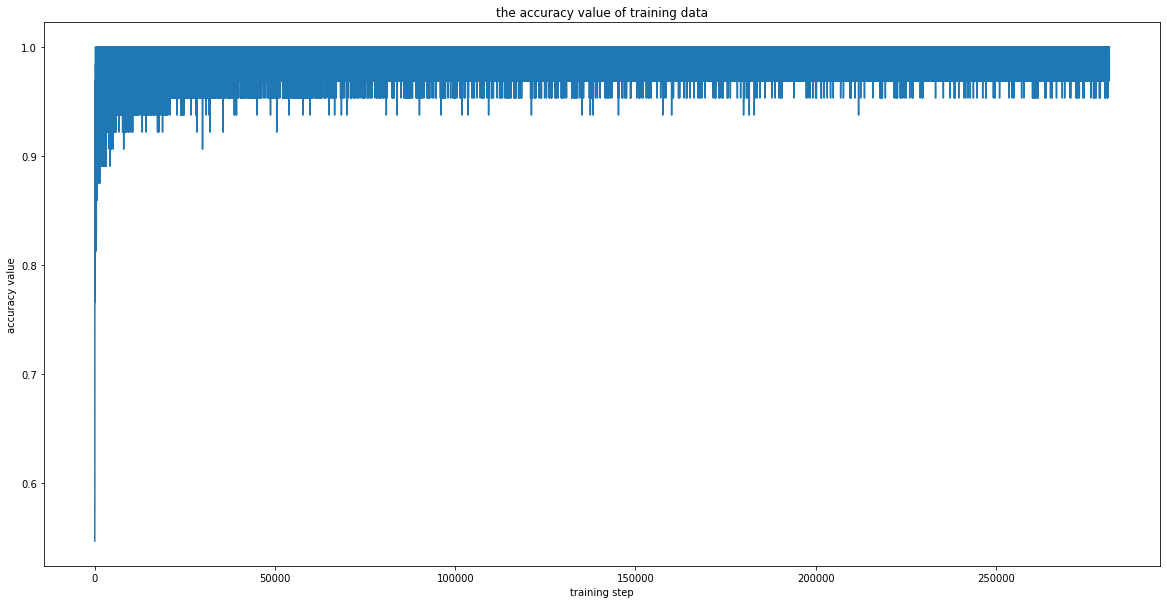

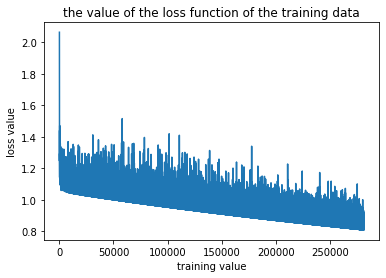

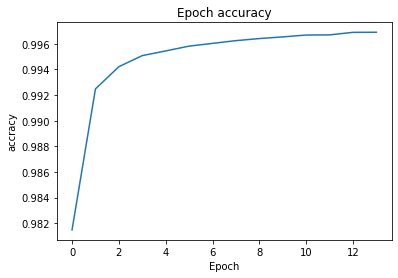

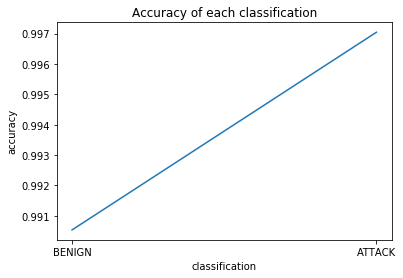

I1204 08:48:30.179039 140128707872576 saver.py:1280] Restoring parameters from model_folder/saver/model.ckpt
W1204 08:48:30.212405 140128707872576 queue_runner_impl.py:471] `tf.train.start_queue_runners()` was called when no queue runners were defined. You can safely remove the call to this deprecated function.


confusion matrix in tensorflow: 
测试precision= 0.9972300288499801
[0.9949803501250447, 0.9987359282579661]


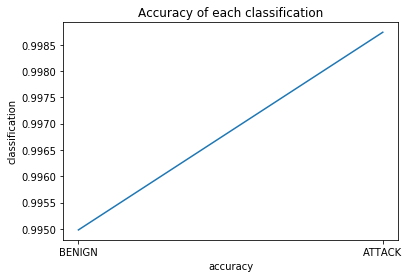

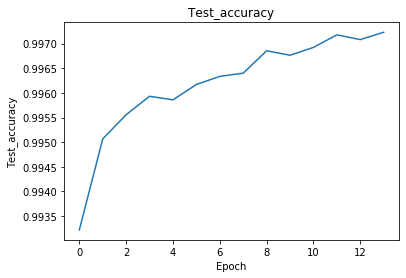

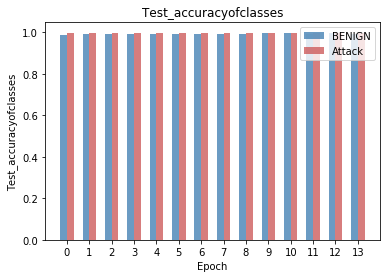

epoch为: 14
index: 0  loss_value: 0.8133979  accuracy_value: 1.0
index: 1000  loss_value: 0.8133476  accuracy_value: 1.0
index: 2000  loss_value: 0.8115384  accuracy_value: 1.0
index: 3000  loss_value: 0.8074507  accuracy_value: 1.0
index: 4000  loss_value: 0.81858844  accuracy_value: 1.0
index: 5000  loss_value: 0.8117099  accuracy_value: 1.0
index: 6000  loss_value: 0.8115552  accuracy_value: 1.0
index: 7000  loss_value: 0.8065401  accuracy_value: 1.0
index: 8000  loss_value: 0.80599713  accuracy_value: 1.0
index: 9000  loss_value: 0.8074891  accuracy_value: 1.0
index: 10000  loss_value: 0.80632937  accuracy_value: 1.0
index: 11000  loss_value: 0.8048788  accuracy_value: 1.0
index: 12000  loss_value: 0.81474453  accuracy_value: 0.984375
index: 13000  loss_value: 0.8109617  accuracy_value: 1.0
index: 14000  loss_value: 0.8110977  accuracy_value: 1.0
index: 15000  loss_value: 0.79902446  accuracy_value: 1.0
index: 16000  loss_value: 0.79875326  accuracy_value: 1.0
index: 17000  loss_val

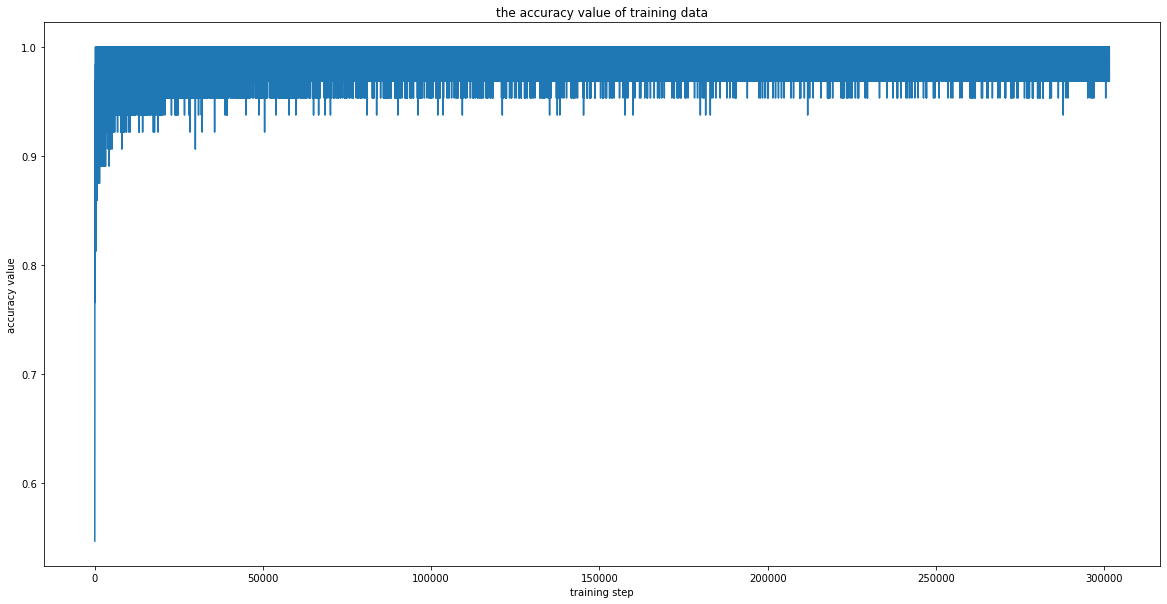

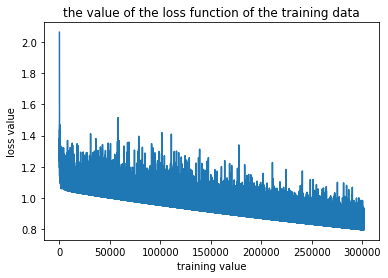

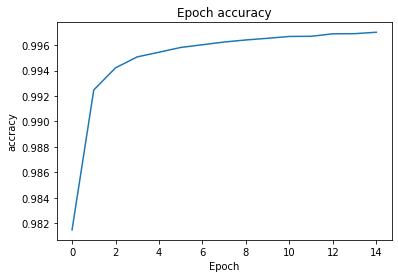

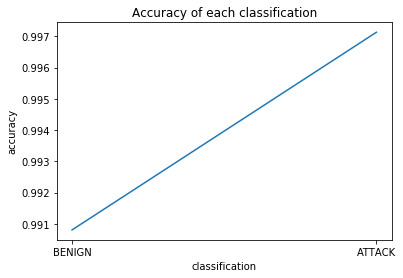

I1204 09:05:13.425410 140128707872576 saver.py:1280] Restoring parameters from model_folder/saver/model.ckpt
W1204 09:05:13.458903 140128707872576 queue_runner_impl.py:471] `tf.train.start_queue_runners()` was called when no queue runners were defined. You can safely remove the call to this deprecated function.


confusion matrix in tensorflow: 
测试precision= 0.997258008356546
[0.9963110507699453, 0.9980681536318712]


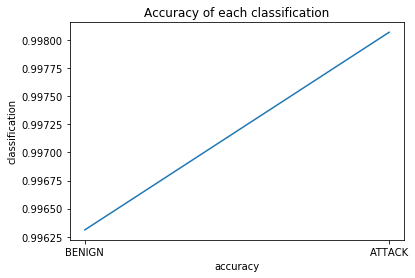

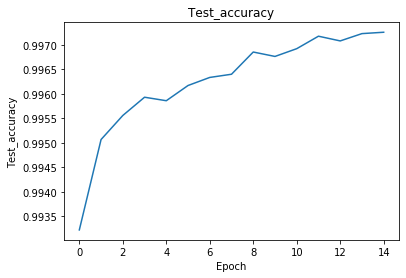

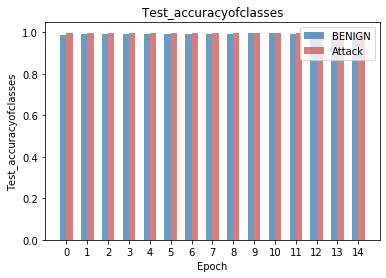

epoch为: 15
index: 0  loss_value: 0.7951765  accuracy_value: 1.0
index: 1000  loss_value: 0.79499876  accuracy_value: 1.0
index: 2000  loss_value: 0.795461  accuracy_value: 1.0
index: 3000  loss_value: 0.79547006  accuracy_value: 1.0
index: 4000  loss_value: 0.79382765  accuracy_value: 1.0
index: 5000  loss_value: 0.7928384  accuracy_value: 1.0
index: 6000  loss_value: 0.79706144  accuracy_value: 1.0
index: 7000  loss_value: 0.7916595  accuracy_value: 1.0
index: 8000  loss_value: 0.790012  accuracy_value: 1.0
index: 9000  loss_value: 0.79211307  accuracy_value: 1.0
index: 10000  loss_value: 0.80918145  accuracy_value: 0.984375
index: 11000  loss_value: 0.8019213  accuracy_value: 0.984375
index: 12000  loss_value: 0.7873569  accuracy_value: 1.0
index: 13000  loss_value: 0.7960473  accuracy_value: 1.0
index: 14000  loss_value: 0.7931835  accuracy_value: 1.0
index: 15000  loss_value: 0.7856455  accuracy_value: 1.0
index: 16000  loss_value: 0.78616226  accuracy_value: 1.0
index: 17000  loss

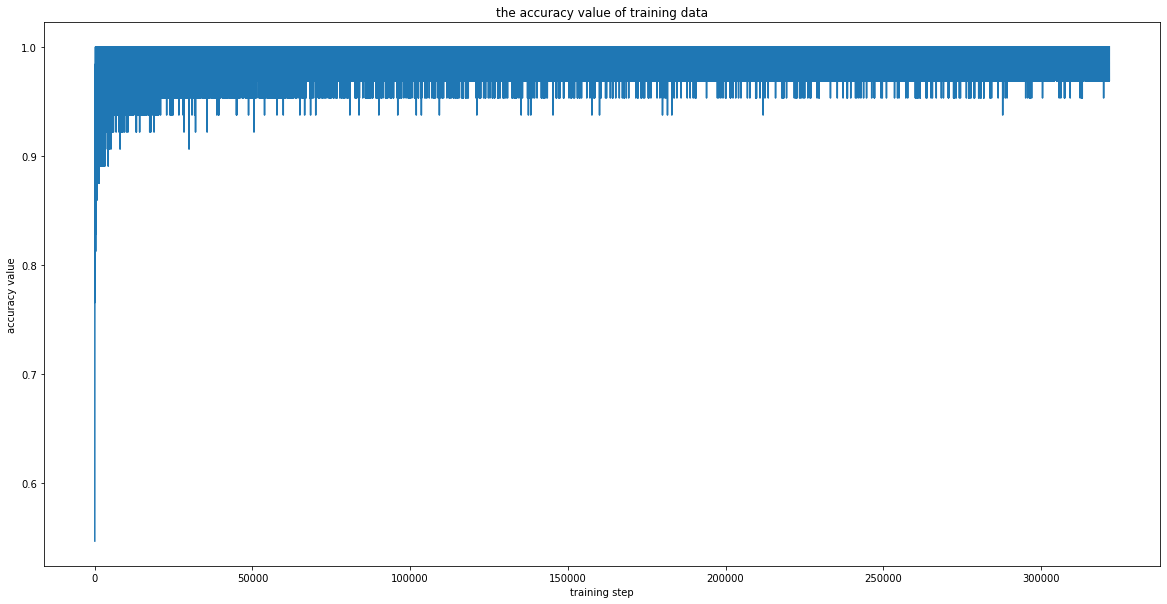

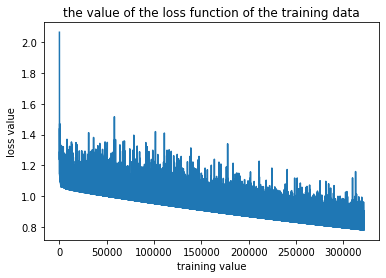

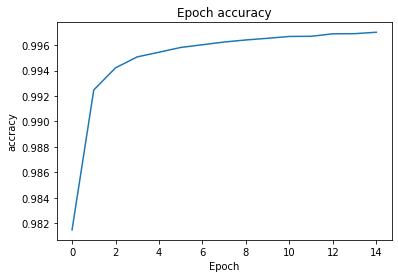

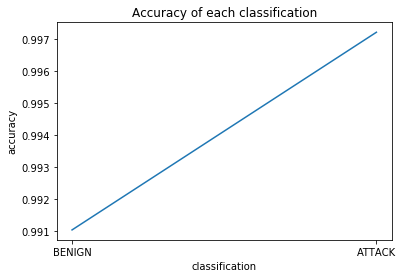

I1204 09:23:00.403560 140128707872576 saver.py:1280] Restoring parameters from model_folder/saver/model.ckpt
W1204 09:23:00.436380 140128707872576 queue_runner_impl.py:471] `tf.train.start_queue_runners()` was called when no queue runners were defined. You can safely remove the call to this deprecated function.


confusion matrix in tensorflow: 
测试precision= 0.9971927228412256
[0.9962575919971418, 0.9979965655409273]


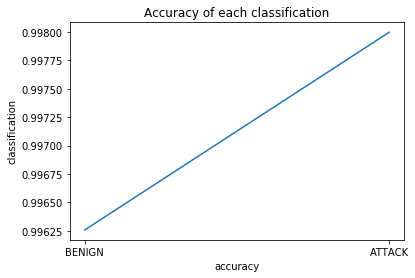

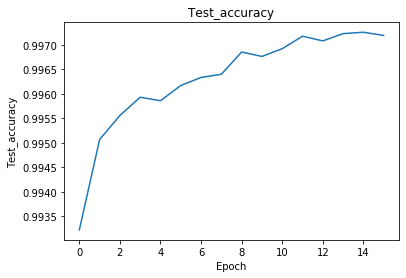

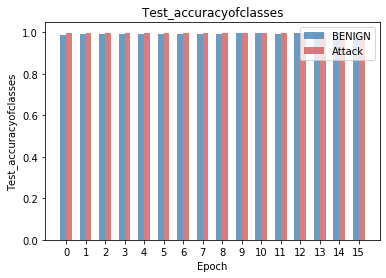

epoch为: 16
index: 0  loss_value: 0.78415173  accuracy_value: 1.0
index: 1000  loss_value: 0.7915222  accuracy_value: 1.0
index: 2000  loss_value: 0.78161377  accuracy_value: 1.0
index: 3000  loss_value: 0.7859992  accuracy_value: 1.0
index: 4000  loss_value: 0.7796918  accuracy_value: 1.0
index: 5000  loss_value: 0.7781755  accuracy_value: 1.0
index: 6000  loss_value: 0.77902734  accuracy_value: 1.0
index: 7000  loss_value: 0.7772219  accuracy_value: 1.0
index: 8000  loss_value: 0.77665406  accuracy_value: 1.0
index: 9000  loss_value: 0.7817653  accuracy_value: 1.0
index: 10000  loss_value: 0.77743137  accuracy_value: 1.0
index: 11000  loss_value: 0.7788165  accuracy_value: 1.0
index: 12000  loss_value: 0.7861736  accuracy_value: 0.984375
index: 13000  loss_value: 0.78915447  accuracy_value: 0.984375
index: 14000  loss_value: 0.7738296  accuracy_value: 1.0
index: 15000  loss_value: 0.7723683  accuracy_value: 1.0
index: 16000  loss_value: 0.7729164  accuracy_value: 1.0
index: 17000  los

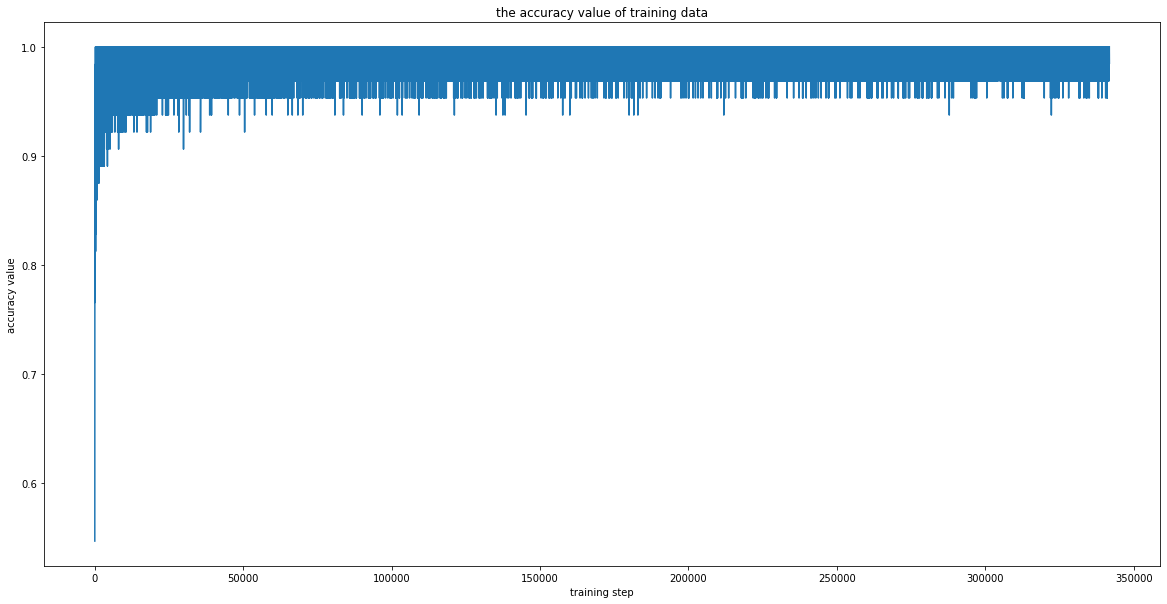

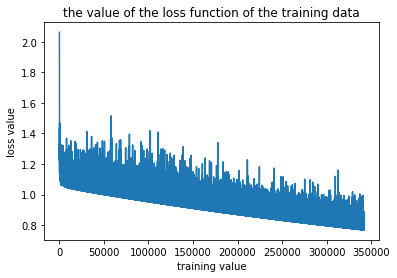

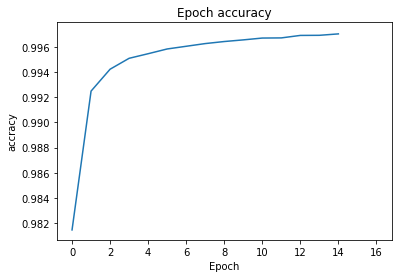

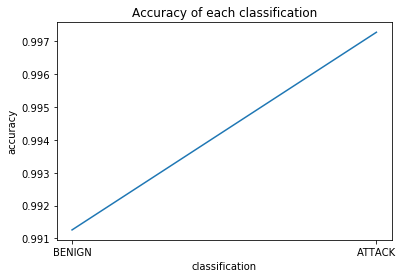

I1204 09:41:26.247425 140128707872576 saver.py:1280] Restoring parameters from model_folder/saver/model.ckpt
W1204 09:41:26.280697 140128707872576 queue_runner_impl.py:471] `tf.train.start_queue_runners()` was called when no queue runners were defined. You can safely remove the call to this deprecated function.


confusion matrix in tensorflow: 
测试precision= 0.997279770194986
[0.995811228408624, 0.9983685852485761]


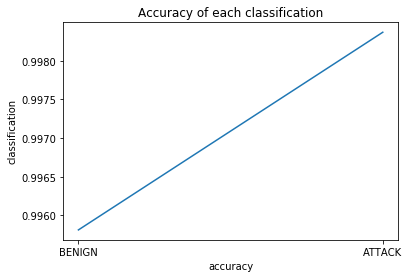

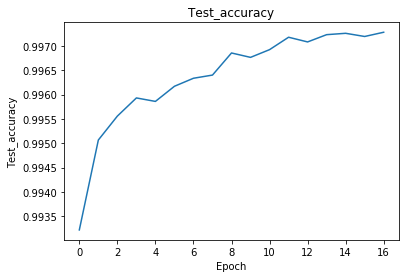

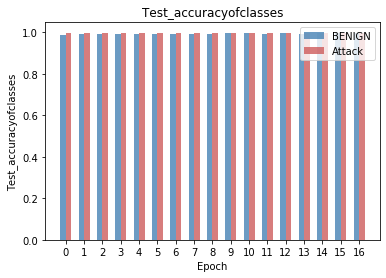

epoch为: 17
index: 0  loss_value: 0.7689405  accuracy_value: 1.0
index: 1000  loss_value: 0.77369946  accuracy_value: 1.0
index: 2000  loss_value: 0.76771206  accuracy_value: 1.0
index: 3000  loss_value: 0.786811  accuracy_value: 0.984375
index: 4000  loss_value: 0.7661347  accuracy_value: 1.0
index: 5000  loss_value: 0.766783  accuracy_value: 1.0
index: 6000  loss_value: 0.76576245  accuracy_value: 1.0
index: 7000  loss_value: 0.79121375  accuracy_value: 0.984375
index: 8000  loss_value: 0.76440704  accuracy_value: 1.0
index: 9000  loss_value: 0.7632521  accuracy_value: 1.0
index: 10000  loss_value: 0.7796204  accuracy_value: 1.0
index: 11000  loss_value: 0.7692442  accuracy_value: 1.0
index: 12000  loss_value: 0.76311743  accuracy_value: 1.0
index: 13000  loss_value: 0.7809434  accuracy_value: 0.984375
index: 14000  loss_value: 0.76261014  accuracy_value: 1.0
index: 15000  loss_value: 0.7677058  accuracy_value: 1.0
index: 16000  loss_value: 0.7613998  accuracy_value: 1.0
index: 17000 

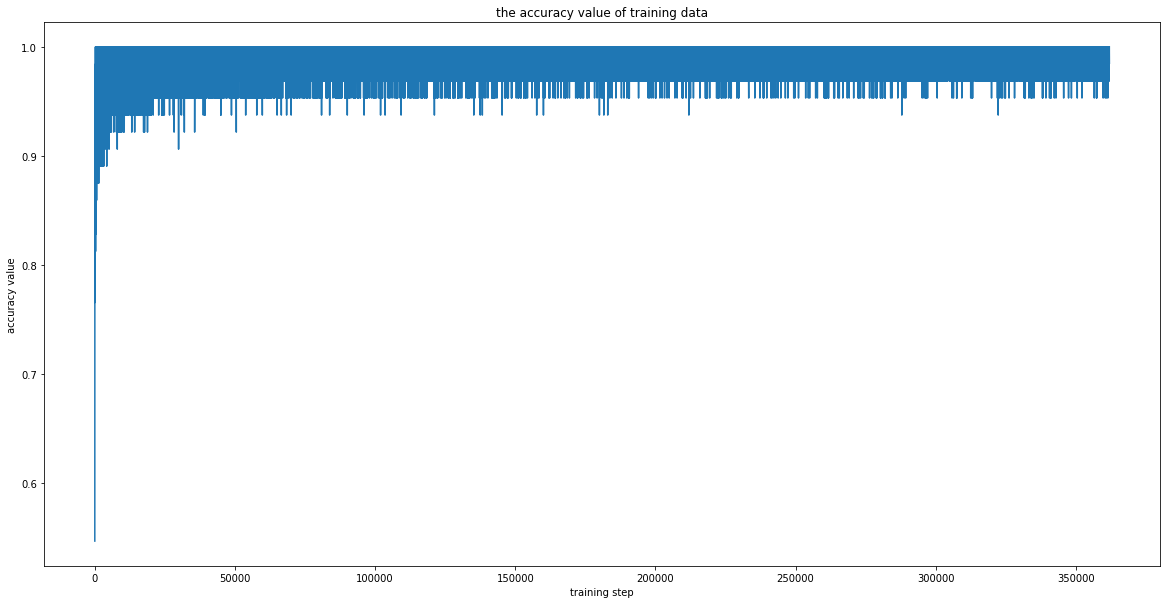

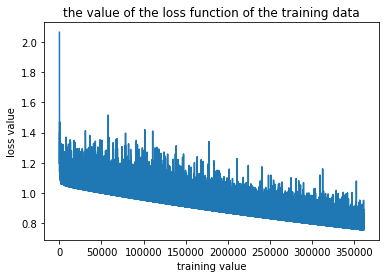

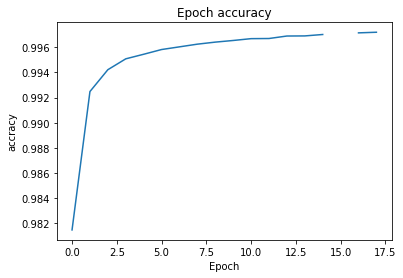

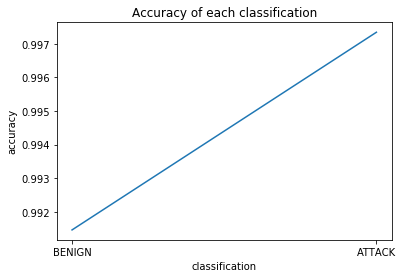

I1204 10:00:46.271600 140128707872576 saver.py:1280] Restoring parameters from model_folder/saver/model.ckpt
W1204 10:00:46.304685 140128707872576 queue_runner_impl.py:471] `tf.train.start_queue_runners()` was called when no queue runners were defined. You can safely remove the call to this deprecated function.


confusion matrix in tensorflow: 
测试precision= 0.9974134500596896
[0.9964184276808202, 0.9982493631879716]


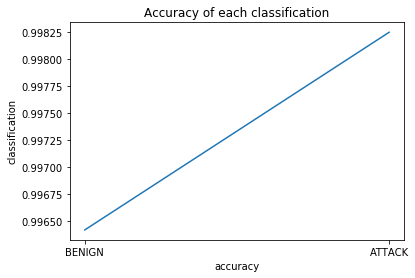

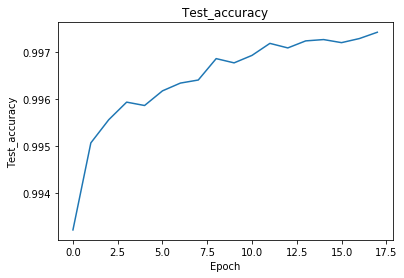

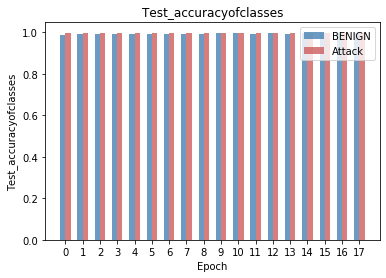

epoch为: 18
index: 0  loss_value: 0.7572083  accuracy_value: 1.0
index: 1000  loss_value: 0.75567454  accuracy_value: 1.0
index: 2000  loss_value: 0.75734985  accuracy_value: 1.0
index: 3000  loss_value: 0.75405544  accuracy_value: 1.0
index: 4000  loss_value: 0.75934345  accuracy_value: 1.0
index: 5000  loss_value: 0.7558891  accuracy_value: 1.0
index: 6000  loss_value: 0.7533249  accuracy_value: 1.0
index: 7000  loss_value: 0.7538776  accuracy_value: 1.0
index: 8000  loss_value: 0.7514558  accuracy_value: 1.0
index: 9000  loss_value: 0.75001603  accuracy_value: 1.0
index: 10000  loss_value: 0.7650187  accuracy_value: 0.984375
index: 11000  loss_value: 0.7510681  accuracy_value: 1.0
index: 12000  loss_value: 0.7501327  accuracy_value: 1.0
index: 13000  loss_value: 0.7581357  accuracy_value: 1.0
index: 14000  loss_value: 0.7477984  accuracy_value: 1.0
index: 15000  loss_value: 0.7512695  accuracy_value: 1.0
index: 16000  loss_value: 0.8317666  accuracy_value: 0.984375
index: 17000  loss

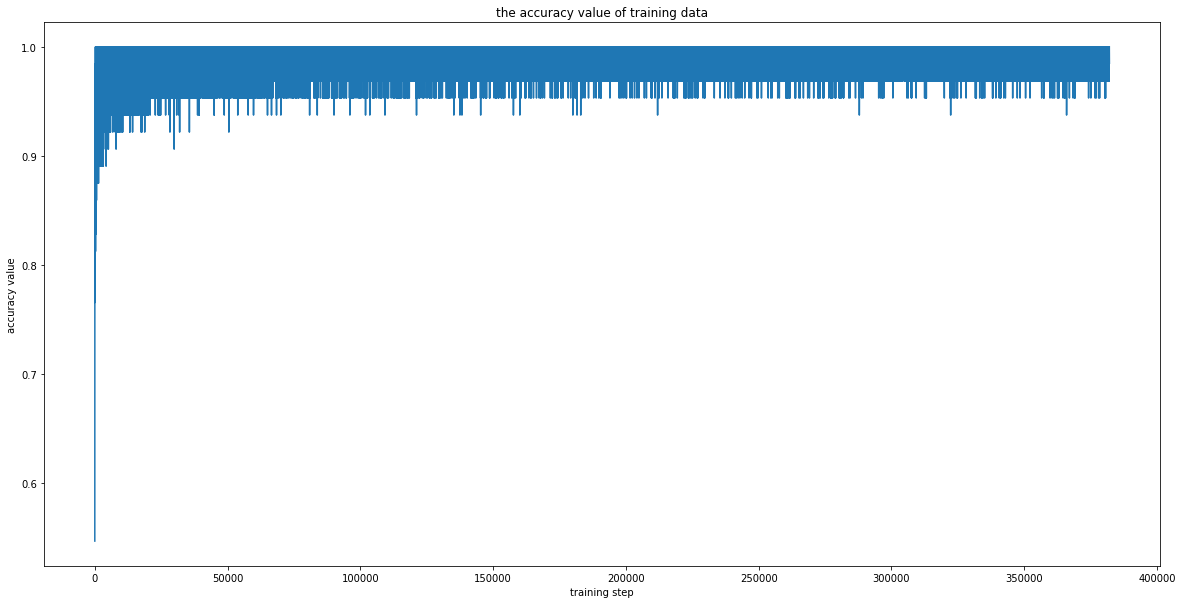

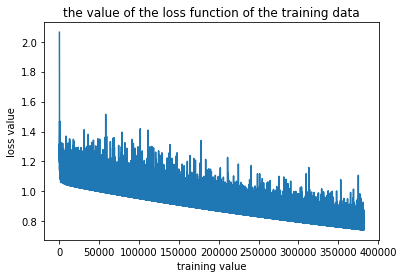

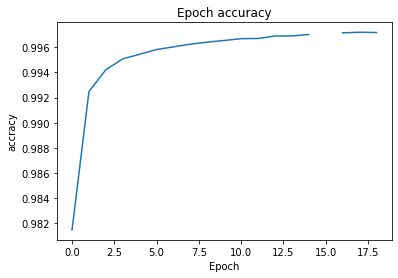

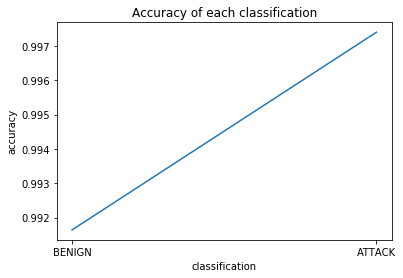

I1204 10:20:54.154134 140128707872576 saver.py:1280] Restoring parameters from model_folder/saver/model.ckpt
W1204 10:20:54.187942 140128707872576 queue_runner_impl.py:471] `tf.train.start_queue_runners()` was called when no queue runners were defined. You can safely remove the call to this deprecated function.


confusion matrix in tensorflow: 
测试precision= 0.9975471299243932
[0.9948731689889246, 0.9992797176111429]


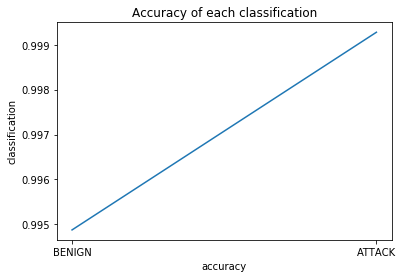

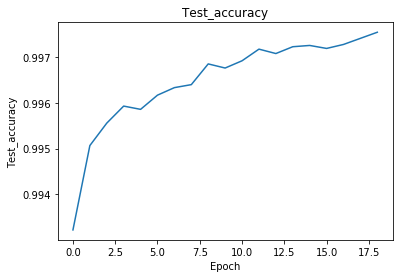

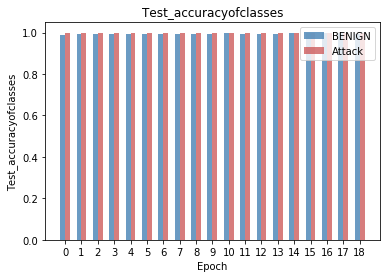

epoch为: 19
index: 0  loss_value: 0.7456414  accuracy_value: 1.0
index: 1000  loss_value: 0.7444094  accuracy_value: 1.0
index: 2000  loss_value: 0.7490313  accuracy_value: 1.0
index: 3000  loss_value: 0.7425639  accuracy_value: 1.0
index: 4000  loss_value: 0.7413839  accuracy_value: 1.0
index: 5000  loss_value: 0.7411713  accuracy_value: 1.0
index: 6000  loss_value: 0.7516331  accuracy_value: 1.0
index: 7000  loss_value: 0.77481717  accuracy_value: 0.96875
index: 8000  loss_value: 0.75956225  accuracy_value: 1.0
index: 9000  loss_value: 0.73815066  accuracy_value: 1.0
index: 10000  loss_value: 0.7390428  accuracy_value: 1.0
index: 11000  loss_value: 0.74414337  accuracy_value: 1.0
index: 12000  loss_value: 0.7433863  accuracy_value: 1.0
index: 13000  loss_value: 0.7473746  accuracy_value: 0.984375
index: 14000  loss_value: 0.75417453  accuracy_value: 0.984375
index: 15000  loss_value: 0.7358138  accuracy_value: 1.0
index: 16000  loss_value: 0.73613256  accuracy_value: 1.0
index: 17000 

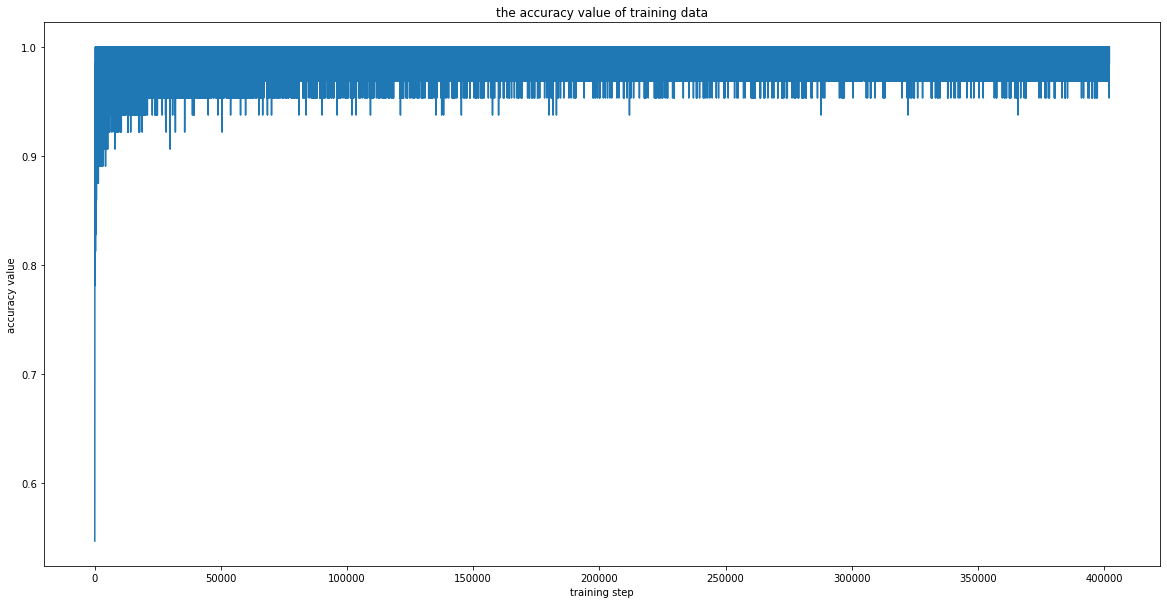

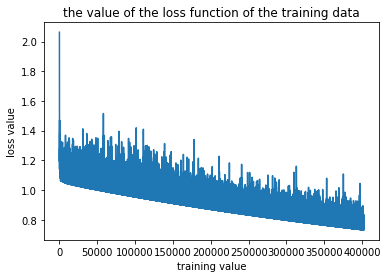

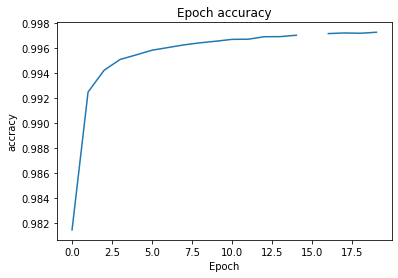

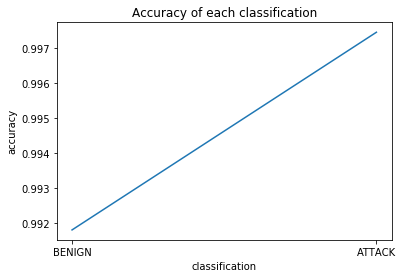

I1204 10:41:41.516161 140128707872576 saver.py:1280] Restoring parameters from model_folder/saver/model.ckpt
W1204 10:41:41.551468 140128707872576 queue_runner_impl.py:471] `tf.train.start_queue_runners()` was called when no queue runners were defined. You can safely remove the call to this deprecated function.


confusion matrix in tensorflow: 
测试precision= 0.9972673348587345
[0.997481333285699, 0.9974574977580186]


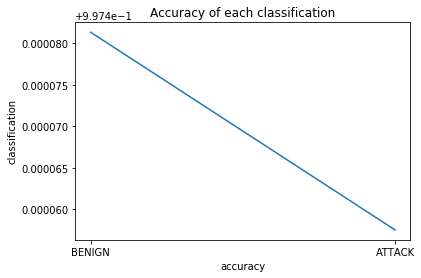

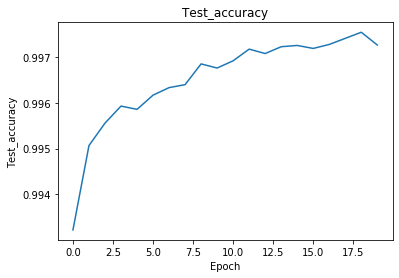

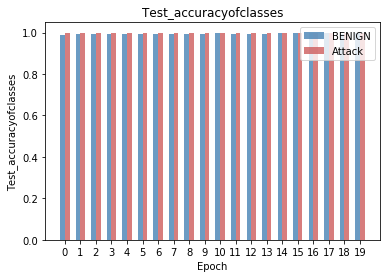

epoch为: 20
index: 0  loss_value: 0.7360262  accuracy_value: 1.0


InvalidArgumentError: Cannot serialize protocol buffer of type tensorflow.GraphDef as the serialized size (2162194689bytes) would be larger than the limit (2147483647 bytes)

In [9]:
if __name__ == '__main__':
    tf.app.run()